
# Statistical Machine Learning Project<br>


# Project Name : IEEE-CIS Fraud Detection

## Submitted by Noor Ayesha

## Data Description

https://www.kaggle.com/competitions/ieee-fraud-detection/data?select=sample_submission.csv

In this Project I am predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

Categorical Features - Transaction
ProductCD
card1 - card6
addr1, addr2
P_emaildomain
R_emaildomain
M1 - M9
Categorical Features - Identity
DeviceType
DeviceInfo
id_12 - id_38
The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

You can read more about the data from this post by the competition host.

Files
train_{transaction, identity}.csv - the training set
test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
sample_submission.csv - a sample submission file in the correct format

Note: As the filesize is huge in order to save from memory loss issues i have taken sample of 50,000 records for my project

## Pipeline Followed

## Load necessary libraries and modules

In [206]:
import pandas as pd
import numpy as np

In [207]:
import math
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import scipy.sparse
import gc
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings 
#from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate

In [208]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [209]:
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from sklearn.model_selection import GridSearchCV
from pandas                 import DataFrame
import sys

In [210]:
from pandas                 import DataFrame
from pandas                 import read_csv
from numpy                  import array
from numpy                  import random

In [211]:
import warnings
# others
warnings.filterwarnings("ignore")
import gc
import copy
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)
# sklearn
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
#from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, f1_score, SCORERS, make_scorer, fbeta_score, roc_curve, auc, plot_roc_curve, precision_recall_curve, precision_recall_curve, plot_precision_recall_curve, plot_confusion_matrix
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
# Visual
import graphviz

## Import Source Files

In [212]:
#Setting up source files path
File_Path = '/Users/noor/Downloads/SML/ieee-fraud-detection/'

In [213]:
#reading both input files of training_data and testing_data
#transaction Files
tr_transaction = pd.read_csv(File_Path + 'train_transaction.csv')
tst_transaction = pd.read_csv(File_Path + 'test_transaction.csv')

In [214]:
#Identity Files
tr_identity = pd.read_csv(File_Path + 'train_identity.csv')
tst_identity = pd.read_csv(File_Path + 'test_identity.csv')

Data size is comparatively large, and training_data and testing_data dataset sizes are similar. To cut down on expensive running time, i might need to conduct experiment using a subsample.

In [215]:
#import sample file
sample_submission = pd.read_csv(File_Path + 'sample_submission.csv')

## Reduce Memory Usage

 Function to reduce the datafrm size

In [216]:
#From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(datafrm,verbose=True):
    numerics = ['int16','int32','int64','float16','float32','float64']
    start_mem = datafrm.memory_usage().sum() / 1024**2    
    for col in datafrm.columns:
        col_type = datafrm[col].dtypes
        if col_type in numerics:
            c_min = datafrm[col].min()
            c_max = datafrm[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    datafrm[col] = datafrm[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    datafrm[col] = datafrm[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    datafrm[col] = datafrm[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    datafrm[col] = datafrm[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    datafrm[col] = datafrm[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    datafrm[col] = datafrm[col].astype(np.float32)
                else:
                    datafrm[col] = datafrm[col].astype(np.float64)    
    end_mem = datafrm.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return datafrm

In [217]:
# Reducing memory of training_data sets
tr_transaction = reduce_mem_usage(tr_transaction)
tr_identity = reduce_mem_usage(tr_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


In [218]:
# Reducing memory of training_data sets
tst_transaction = reduce_mem_usage(tst_transaction)
tst_identity = reduce_mem_usage(tst_identity)

Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [219]:
gc.collect()

3717

## EDA

In [220]:
#Subsetting categorical columns
cat_cols = [ 'addr1', 'addr2',
             'card1','card2', 'card3', 'card4', 'card5', 'card6',
             'DeviceType', 'DeviceInfo',
             'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9','id_12', 'id_13', 'id_14', 
             'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
             'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
             'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
             'ProductCD','P_emaildomain', 'R_emaildomain']

In [221]:
#writing a function to check Summary of dataset
def check_datafrm_summary(datafrm):
    print(f"Dataframe Shape: {datafrm.shape}")
    summary = pd.DataFrame(datafrm.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Variable'] = summary['index']
    summary = summary[['Variable','dtypes']]
    summary['Missing Records'] = datafrm.isnull().sum().values    
    summary['Unique Records'] = datafrm.nunique().values
    return summary

In [222]:
check_datafrm_summary(tr_transaction)

Dataframe Shape: (590540, 394)


Variable   dtypes  Missing Records  Unique Records
0     TransactionID    int32                0          590540
1           isFraud     int8                0               2
2     TransactionDT    int32                0          573349
3    TransactionAmt  float16                0            8195
4         ProductCD   object                0               5
5             card1    int16                0           13553
6             card2  float16             8933             500
7             card3  float16             1565             114
8             card4   object             1577               4
9             card5  float16             4259             119
10            card6   object             1571               4
11            addr1  float16            65706             332
12            addr2  float16            65706              74
13            dist1  float16           352271            2412
14            dist2  float16           552913            1699
15    P_emaildomain   object            94456              59
16    R_emaildomain   object           453249              60
17               C1  float16                0            1495
18               C2  float16                0            1167
19               C3  float16                0              27
20               C4  float16                0            1223
21               C5  float16                0             319
22               C6  float16                0            1291
23               C7  float16                0            1069
24               C8  float16                0            1130
25               C9  float16                0             205
26              C10  float16                0            1122
27              C11  float16                0            1343
28              C12  float16                0            1066
29              C13  float16                0            1464
30              C14  float16                0            1108
31               D1  float16             1269             641
32               D2  float16           280797             641
33               D3  float16           262878             649
34               D4  float16           168922             808
35               D5  float16           309841             688
36               D6  float16           517353             829
37               D7  float16           551623             597
38               D8  float16           515614            5367
39               D9  float16           515614              24
40              D10  float16            76022             818
41              D11  float16           279287             676
42              D12  float16           525823             635
43              D13  float16           528588             577
44              D14  float16           528353             802
45              D15  float16            89113             859
46               M1   object           271100               2
47               M2   object           271100               2
48               M3   object           271100               2
49               M4   object           281444               3
50               M5   object           350482               2
51               M6   object           169360               2
52               M7   object           346265               2
53               M8   object           346252               2
54               M9   object           346252               2
55               V1  float16           279287               2
56               V2  float16           279287               9
57               V3  float16           279287              10
58               V4  float16           279287               7
59               V5  float16           279287               7
60               V6  float16           279287              10
61               V7  float16           279287              10
62               V8  float16           279287               9
63               V9  float16           2792

In [223]:
#Checking card features
check_datafrm_summary(tr_transaction[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataframe Shape: (590540, 6)


Variable   dtypes  Missing Records  Unique Records
0    card1    int16                0           13553
1    card2  float16             8933             500
2    card3  float16             1565             114
3    card4   object             1577               4
4    card5  float16             4259             119
5    card6   object             1571               4

in columns with categories Card1 has 13553 unique records, thus encoding CARD columns will result in hundreds of columns being created. This is not the best option, so I must analyze each variable and make the required feature engineering decisions.

In [224]:
#Checking Catagorical features
catagorical_features=tr_transaction.select_dtypes(include=['category','object']).columns
catagorical_features

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [225]:
#Checking Continous features
continuous_features = list(filter(lambda x: x not in catagorical_features, tr_transaction))
continuous_features

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'card2',
 'card3',
 'card5',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',


In [226]:
gc.collect()

0

### Merging both files and deleting Source files in order to save memory space

In [227]:
#Merging both the files based on TransactionID
training_data = pd.merge(tr_transaction,tr_identity, on='TransactionID', how='left')
testing_data = pd.merge(tst_transaction,tst_identity, on='TransactionID', how='left')

In [228]:
#deleting original files
del tr_transaction,tst_transaction,tr_identity,tst_identity
gc.collect()

0

In [229]:
training_data.head(5)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   
2  490.0  150.0        visa  166.0   debit  330.0   87.0  287.0    NaN   
3  567.0  150.0  mastercard  117.0   debit  476.0   87.0    NaN    NaN   
4  514.0  150.0  mastercard  102.0  credit  420.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2   outlook.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3     yahoo.com           NaN  2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

   C10  C11  C12   C13  C14     D1     D2    D3    D4   D5  D6  D7  D8  D9  \
0  0.0  2.0  0.0   1.0  1.0   14.0    NaN  13.0   NaN  NaN NaN NaN NaN NaN   
1  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
2  0.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   0.0  NaN NaN NaN NaN NaN   
3  0.0  1.0  0.0  25.0  1.0  112.0  112.0   0.0  94.0  0.0 NaN NaN NaN NaN   
4  1.0  1.0  0.0   1.0  1.0    0.0    NaN   NaN   NaN  NaN NaN NaN NaN NaN   

    D10    D11  D12  D13  D14    D15   M1   M2   M3   M4   M5   M6   M7   M8  \
0  13.0   13.0  NaN  NaN  NaN    0.0    T    T    T   M2    F    T  NaN  NaN   
1   0.0    NaN  NaN  NaN  NaN    0.0  NaN  NaN  NaN   M0    T    T  NaN  NaN   
2   0.0  315.0  NaN  NaN  NaN  315.0    T    T    T   M0    F    F    F    F   
3  84.0    NaN  NaN  NaN  NaN  111.0  NaN  NaN  NaN   M0    T    F  NaN  NaN   
4   NaN    NaN  NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  \
0  NaN  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0   
2    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  \
0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  

In [230]:
testing_data.head(5)

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224       31.953125         W  10409  111.0   
1        3663550       18403263       49.000000         W   4272  111.0   
2        3663551       18403310      171.000000         W   4476  574.0   
3        3663552       18403310      285.000000         W  10989  360.0   
4        3663553       18403317       67.937500         W  18018  452.0   

   card3       card4  card5  card6  addr1  addr2   dist1  dist2 P_emaildomain  \
0  150.0        visa  226.0  debit  170.0   87.0     1.0    NaN     gmail.com   
1  150.0        visa  226.0  debit  299.0   87.0     4.0    NaN       aol.com   
2  150.0        visa  226.0  debit  472.0   87.0  2636.0    NaN   hotmail.com   
3  150.0        visa  166.0  debit  205.0   87.0    17.0    NaN     gmail.com   
4  150.0  mastercard  117.0  debit  264.0   87.0     6.0    NaN     gmail.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   
2           NaN  2.0  2.0  0.0  0.0  0.0  5.0  0.0  0.0  4.0  0.0  2.0  0.0   
3           NaN  5.0  2.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  2.0  0.0   
4           NaN  6.0  6.0  0.0  0.0  2.0  5.0  0.0  0.0  5.0  0.0  6.0  0.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   
2   22.0  2.0  137.0  137.0  10.0   97.0  10.0 NaN NaN NaN NaN  136.0  136.0   
3    7.0  4.0   42.0   42.0  41.0  242.0  41.0 NaN NaN NaN NaN  242.0  242.0   
4   14.0  6.0   22.0   22.0   0.0   22.0   0.0 NaN NaN NaN NaN   22.0   22.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   
2  NaN  NaN  NaN   97.0  T  T  F   M0    F  F    F    F    F  1.0  1.0  1.0   
3  NaN  NaN  NaN  242.0  T  T  T  NaN  NaN  T  NaN  NaN  NaN  1.0  1.0  1.0   
4  NaN  NaN  NaN   22.0  T  T  T  NaN  NaN  F    F    T    T  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  1.0  1.0  0.0  0.0  2.0  2.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
4  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
2  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
3  0.0  2.0  2.0  2.0  2.0  0.0  0.0  1.0  0.0  0.0  2.0  2.0  2.0  2.0  1.0   
4  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0

In [231]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


In [232]:
gc.collect()

0

## Take Sample of Dataset as the filesize is huge

In [233]:
training_data_sample = training_data.sample(n=50000)
testing_data_sample = testing_data.sample(n=50000)

In [234]:
training_data_sample.shape

(50000, 434)

In [235]:
testing_data_sample.shape

(50000, 433)

In [236]:
#reassign this sample subset to training and testing data
training_data = training_data_sample
testing_data = testing_data_sample

In [237]:
training_data.shape

(50000, 434)

In [238]:
testing_data.shape

(50000, 433)

### Renaming id01 to id38 columns in testing_data to be in sync with training_data column names

In [239]:
#Check column names in testing_data dataset
print(testing_data.iloc[:, 393:431].columns)

Index(['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08',
       'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16',
       'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24',
       'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32',
       'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38'],
      dtype='object')


In [240]:
#Check column names in training_data dataset
print(training_data.iloc[:, 394:432].columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'],
      dtype='object')


In [241]:
testing_data.rename(columns= {'id-01' : 'id_01','id-02' : 'id_02','id-03' : 'id_03','id-04' : 'id_04',
                      'id-05' : 'id_05','id-06' : 'id_06','id-07' : 'id_07','id-08' : 'id_08',
                      'id-09' : 'id_09','id-10' : 'id_10','id-11' : 'id_11','id-12' : 'id_12',
                      'id-13' : 'id_13','id-14' : 'id_14','id-15' : 'id_15','id-16' : 'id_16',
                      'id-17' : 'id_17','id-18' : 'id_18','id-19' : 'id_19','id-20' : 'id_20',
                      'id-21' : 'id_21','id-22' : 'id_22','id-23' : 'id_23','id-24' : 'id_24',
                      'id-25' : 'id_25','id-26' : 'id_26','id-27' : 'id_27','id-28' : 'id_28',
                      'id-29' : 'id_29','id-30' : 'id_30','id-31' : 'id_31','id-32' : 'id_32',
                      'id-33' : 'id_33','id-34' : 'id_34','id-35' : 'id_35','id-36' : 'id_36',
                      'id-37' : 'id_37','id-38' : 'id_38',
                     },inplace=True)

In [242]:
#check column names in testing_data dataset
print(testing_data.iloc[:, 393:431].columns)

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'],
      dtype='object')


## Missing Values

In [243]:
#Checking nulls in each variable and also the datatype in training_data data
for i in training_data.columns:
    print(i,'count of NaN values of var is:',training_data[i].isnull().sum(),end=" ")
    print('percentage of NaN values is:',np.round(training_data[i].isnull().sum()/training_data.shape[0]*100,2))
    print('The datatype of var is:',training_data[i].dtypes,end=" ")
    

TransactionID count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int32 isFraud count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int8 TransactionDT count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int32 TransactionAmt count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 ProductCD count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: object card1 count of NaN values of var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int16 card2 count of NaN values of var is: 777 percentage of NaN values is: 1.55
The datatype of var is: float16 card3 count of NaN values of var is: 112 percentage of NaN values is: 0.22
The datatype of var is: float16 card4 count of NaN values of var is: 112 percentage of NaN values is: 0.22
The datatype of var is: object card5 count of NaN values of var is

The datatype of var is: float16 V113 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V114 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V115 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V116 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V117 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V118 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V119 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V120 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V121 count of NaN values of var is: 35 percentage of NaN values is: 0.07
The datatype of var is: float16 V122 count of NaN value

The datatype of var is: float16 V287 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V288 count of NaN values of var is: 120 percentage of NaN values is: 0.24
The datatype of var is: float16 V289 count of NaN values of var is: 120 percentage of NaN values is: 0.24
The datatype of var is: float16 V290 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V291 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V292 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V293 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V294 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V295 count of NaN values of var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float16 V296 count of NaN values of var is:

In [244]:
#Checking nulls in each variable and also the datatype in testing_data data
for i in testing_data.columns:
    print(i,'count of NaN values in this var is:',testing_data[i].isnull().sum(),end=" ")
    print('percentage of NaN values is:',np.round(testing_data[i].isnull().sum()/testing_data.shape[0]*100,2))
    print('The datatype of var is:',testing_data[i].dtypes,end=" ")

TransactionID count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int32 TransactionDT count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int32 TransactionAmt count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 ProductCD count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: object card1 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: int16 card2 count of NaN values in this var is: 870 percentage of NaN values is: 1.74
The datatype of var is: float16 card3 count of NaN values in this var is: 296 percentage of NaN values is: 0.59
The datatype of var is: float16 card4 count of NaN values in this var is: 304 percentage of NaN values is: 0.61
The datatype of var is: object card5 count of NaN values in this var is: 443 percentage of NaN values is: 0.89
The datatype of va

The datatype of var is: float16 V22 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V23 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V24 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V25 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V26 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V27 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V28 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V29 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
The datatype of var is: float16 V30 count of NaN values in this var is: 1215 percentage of NaN values is: 2.43
T

The datatype of var is: float16 V116 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V117 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V118 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V119 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V120 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V121 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V122 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V123 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: float16 V124 count of NaN values in this var is: 0 percentage of NaN values is: 0.0
The datatype of var is: floa

The datatype of var is: float16 V219 count of NaN values in this var is: 37535 percentage of NaN values is: 75.07
The datatype of var is: float16 V220 count of NaN values in this var is: 36489 percentage of NaN values is: 72.98
The datatype of var is: float16 V221 count of NaN values in this var is: 36489 percentage of NaN values is: 72.98
The datatype of var is: float16 V222 count of NaN values in this var is: 36489 percentage of NaN values is: 72.98
The datatype of var is: float16 V223 count of NaN values in this var is: 37535 percentage of NaN values is: 75.07
The datatype of var is: float16 V224 count of NaN values in this var is: 37535 percentage of NaN values is: 75.07
The datatype of var is: float16 V225 count of NaN values in this var is: 37535 percentage of NaN values is: 75.07
The datatype of var is: float16 V226 count of NaN values in this var is: 37535 percentage of NaN values is: 75.07
The datatype of var is: float16 V227 count of NaN values in this var is: 36489 percentag

The datatype of var is: float16 V316 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V317 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V318 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V319 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V320 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V321 count of NaN values in this var is: 1 percentage of NaN values is: 0.0
The datatype of var is: float32 V322 count of NaN values in this var is: 42530 percentage of NaN values is: 85.06
The datatype of var is: float16 V323 count of NaN values in this var is: 42530 percentage of NaN values is: 85.06
The datatype of var is: float16 V324 count of NaN values in this var is: 42530 percentage of NaN values is: 85.06
The dataty

In [245]:
#check summary of training data
sum_training_data_miss = check_datafrm_summary(training_data)
sum_training_data_miss

Dataframe Shape: (50000, 434)


Variable   dtypes  Missing Records  Unique Records
0     TransactionID    int32                0           50000
1           isFraud     int8                0               2
2     TransactionDT    int32                0           49877
3    TransactionAmt  float16                0            3840
4         ProductCD   object                0               5
5             card1    int16                0            5693
6             card2  float16              777             498
7             card3  float16              112              62
8             card4   object              112               4
9             card5  float16              340              76
10            card6   object              112               3
11            addr1  float16             5475             133
12            addr2  float16             5475              27
13            dist1  float16            29681            1310
14            dist2  float16            46937             625
15    P_emaildomain   object             7969              59
16    R_emaildomain   object            38381              52
17               C1  float16                0             437
18               C2  float16                0             427
19               C3  float16                0               7
20               C4  float16                0             234
21               C5  float16                0             264
22               C6  float16                0             356
23               C7  float16                0             175
24               C8  float16                0             250
25               C9  float16                0             176
26              C10  float16                0             265
27              C11  float16                0             372
28              C12  float16                0             209
29              C13  float16                0             789
30              C14  float16                0             348
31               D1  float16              120             640
32               D2  float16            23718             640
33               D3  float16            22221             507
34               D4  float16            14369             681
35               D5  float16            26098             576
36               D6  float16            43884             535
37               D7  float16            46705             337
38               D8  float16            43621            2604
39               D9  float16            43621              24
40              D10  float16             6551             694
41              D11  float16            23677             663
42              D12  float16            44583             471
43              D13  float16            44837             270
44              D14  float16            44873             471
45              D15  float16             7651             709
46               M1   object            22982               2
47               M2   object            22982               2
48               M3   object            22982               2
49               M4   object            24135               3
50               M5   object            29934               2
51               M6   object            14339               2
52               M7   object            29416               2
53               M8   object            29415               2
54               M9   object            29415               2
55               V1  float16            23677               2
56               V2  float16            23677               7
57               V3  float16            23677               7
58               V4  float16            23677               6
59               V5  float16            23677               7
60               V6  float16            23677               6
61               V7  float16            23677               7
62               V8  float16            23677               5
63               V9  float16            236

In [246]:
#Check variables that are missing more than seventy percent data in trainset
col_70missing = sum_training_data_miss[sum_training_data_miss['Missing Records'] >70]['Variable'].to_list()
print('Variables with more than 70% missing data in training_data are: ')
col_70missing

Variables with more than 70% missing data in training_data are: 


['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89

In [247]:
sum_testing_data_miss = check_datafrm_summary(testing_data)
sum_testing_data_miss

Dataframe Shape: (50000, 433)


Variable   dtypes  Missing Records  Unique Records
0     TransactionID    int32                0           50000
1     TransactionDT    int32                0           49885
2    TransactionAmt  float16                0            3238
3         ProductCD   object                0               5
4             card1    int16                0            5748
5             card2  float16              870             496
6             card3  float16              296              76
7             card4   object              304               4
8             card5  float16              443              68
9             card6   object              296               2
10            addr1  float16             6510             139
11            addr2  float16             6510              33
12            dist1  float16            28761            1047
13            dist2  float16            46431             700
14    P_emaildomain   object             6841              59
15    R_emaildomain   object            36621              59
16               C1  float16                0             407
17               C2  float16                0             420
18               C3  float16                0               7
19               C4  float16                0             182
20               C5  float16                0             286
21               C6  float16                0             302
22               C7  float16                0             140
23               C8  float16                0             181
24               C9  float16                0             205
25              C10  float16                0             188
26              C11  float16                0             348
27              C12  float16                0             177
28              C13  float16              482             738
29              C14  float16                0             282
30               D1  float16              576             641
31               D2  float16            23221             641
32               D3  float16            20059             638
33               D4  float16             7602             930
34               D5  float16            22097             749
35               D6  float16            37696             806
36               D7  float16            44050             518
37               D8  float16            42656            2888
38               D9  float16            42656              24
39              D10  float16             1212             946
40              D11  float16            17453             874
41              D12  float16            43133             665
42              D13  float16            37808             418
43              D14  float16            38649             712
44              D15  float16             1160             953
45               M1   object            17464               2
46               M2   object            17464               2
47               M3   object            17464               2
48               M4   object            23228               3
49               M5   object            30344               2
50               M6   object            15624               2
51               M7   object            23184               2
52               M8   object            23182               2
53               M9   object            23182               2
54               V1  float16            17453               1
55               V2  float16            17453               7
56               V3  float16            17453              10
57               V4  float16            17453               7
58               V5  float16            17453               8
59               V6  float16            17453               6
60               V7  float16            17453               7
61               V8  float16            17453               6
62               V9  float16            17453               7
63              V10  float16            174

In [248]:
#Check variables that are missing more than seventy percent data in testset
col_70missing_testing_data = sum_testing_data_miss[sum_testing_data_miss['Missing Records'] >70]['Variable'].to_list()
print('Variables with more than 70% missing data in training_data are: ')
col_70missing_testing_data

Variables with more than 70% missing data in training_data are: 


['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C13',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88

The datasets have a high percentage of missing values; more than 47% of the characteristics have more than 70% of their values missing. 
Similar percentages of features in the training_data and testing_data sets have missing values in them at varying percentages. 
2 percent of features have missing values that are greater than 90 percent, while 2 percent of features have missing values that are greater than 99 percent. 
I can thus think about removing these features after further consideration. 
In the testing_data set, there is only one feature, V107, with a singular value. I can get rid of it because having just one unique value might indicate that it doesn't have any important information.

In [249]:
#Reduce memory
training_data=reduce_mem_usage(training_data)
testing_data=reduce_mem_usage(testing_data)
print('training_dataset shape:', training_data.shape)
print('testing_dataset shape:', testing_data.shape)

Mem. usage decreased to 54.12 Mb (1.7% reduction)
Mem. usage decreased to 55.31 Mb (0.9% reduction)
training_dataset shape: (50000, 434)
testing_dataset shape: (50000, 433)


In [250]:
gc.collect()

0

## Target Distribution

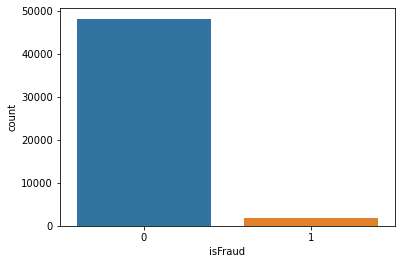

From total data  3.52 % contains fraud training_data
From total data  96.48 % contains legit training_data


In [251]:
#Checking target distribution for fraud values in training_data
sns.countplot(training_data['isFraud'])
plt.show()
print('From total data ',np.round(training_data[training_data['isFraud']==1].shape[0]/training_data.shape[0]*100,2),'% contains fraud training_data')
print('From total data ',np.round(training_data[training_data['isFraud']==0].shape[0]/training_data.shape[0]*100,2),'% contains legit training_data')

Extremely imbalanced, with the training data dataset's 3.53 percent of Transactions that were fake. 

### Analysis on all remaing variables of both training_data and testing_data

In [252]:
#writing a function to describe the characterstics of all the variables
def describe_variable(datatraining_data,datatesting_data,feature):
    d = pd.DataFrame(columns=[feature,'training_data','training_dataFraud','training_dataLegit','testing_data'])
    d[feature] = ['count','mean','std','min','25%','50%','75%','max','unique','NaN','NaNshare']
    for i in range(0,8):
        d['training_data'].iloc[i] = datatraining_data[feature].describe().iloc[i]
        d['training_dataFraud'].iloc[i]=datatraining_data[datatraining_data['isFraud']==1][feature].describe().iloc[i]
        d['training_dataLegit'].iloc[i]=datatraining_data[datatraining_data['isFraud']==0][feature].describe().iloc[i]
        d['testing_data'].iloc[i]=datatesting_data[feature].describe().iloc[i]
    d['training_data'].iloc[8] = len(datatraining_data[feature].unique())
    d['training_dataFraud'].iloc[8]=len(datatraining_data[datatraining_data['isFraud']==1][feature].unique())
    d['training_dataLegit'].iloc[8]=len(datatraining_data[datatraining_data['isFraud']==0][feature].unique())
    d['testing_data'].iloc[8]=len(datatesting_data[feature].unique())
    d['training_data'].iloc[9] = datatraining_data[feature].isnull().sum()
    d['training_dataFraud'].iloc[9] = datatraining_data[datatraining_data['isFraud']==1][feature].isnull().sum()
    d['training_dataLegit'].iloc[9] = datatraining_data[datatraining_data['isFraud']==0][feature].isnull().sum()
    d['testing_data'].iloc[9]=datatesting_data[feature].isnull().sum()
    d['training_data'].iloc[10] = datatraining_data[feature].isnull().sum()/len(datatraining_data)
    d['training_dataFraud'].iloc[10] = datatraining_data[datatraining_data['isFraud']==1][feature].isnull().sum()/len(datatraining_data[datatraining_data['isFraud']==1])
    d['training_dataLegit'].iloc[10] = datatraining_data[datatraining_data['isFraud']==0][feature].isnull().sum()/len(datatraining_data[datatraining_data['isFraud']==0])
    d['testing_data'].iloc[10]=datatesting_data[feature].isnull().sum()/len(datatesting_data)
    return d

In [253]:
gc.collect()

2522

## TransactionDT

In [254]:
transactionDTDescribe = describe_variable(training_data,testing_data,'TransactionDT')
transactionDTDescribe

TransactionDT   training_data training_dataFraud training_dataLegit  \
0          count         50000.0             1761.0            48239.0   
1           mean   7340309.18296     7526716.189665     7333504.258753   
2            std  4614412.495345     4386116.508445     4622434.385101   
3            min         86510.0           106603.0            86510.0   
4            25%       3007813.5          3947789.0          2992756.5   
5            50%       7242062.0          7324638.0          7239215.0   
6            75%     11228354.75         10899089.0         11233239.5   
7            max      15811030.0         15807516.0         15811030.0   
8         unique           49877               1761              48123   
9            NaN               0                  0                  0   
10      NaNshare             0.0                0.0                0.0   

      testing_data  
0          50000.0  
1   26944574.27856  
2   4751488.309849  
3       18403387.0  
4       22777063.5  
5       27206817.0  
6       31356243.0  
7       34213473.0  
8            49885  
9                0  
10             0.0

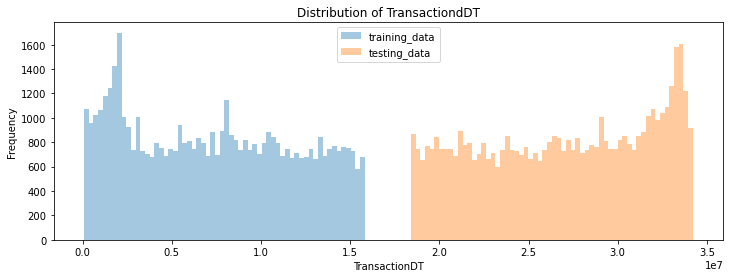

In [255]:
#plot TransactionDT Frequency
plt.figure(figsize=(12,4))
sns.distplot(training_data['TransactionDT'],kde=False,bins=60)
sns.distplot(testing_data['TransactionDT'],kde=False,bins=60)
plt.legend(['training_data','testing_data'])
plt.ylabel('Frequency')
plt.title('Distribution of TransactiondDT');
plt.show()

This plot indicates that the testing_data that is given to us is ahead of training_data
Both at the beginning of the training_data's run and at the end of the testing_data, the transactions are high.

In [256]:
training_data_span = (training_data['TransactionDT'].max() - training_data['TransactionDT'].min())/(3600*24)
testing_data_span = (testing_data['TransactionDT'].max() - testing_data['TransactionDT'].min())/(3600*24)
total_span = (testing_data['TransactionDT'].max() - training_data['TransactionDT'].min())/(3600*24)
gap_span = (testing_data['TransactionDT'].min() - training_data['TransactionDT'].max())/(3600*24)
print('Time span of training_data is {:.2f} days'.format(training_data_span))
print('Time span of testing_data is {:.2f} days'.format(testing_data_span))
print('Time span of Entire dataset is {:.2f} days'.format(total_span))
print('Time gap between training_data and testing_data is {:.2f} days'.format(gap_span))

Time span of training_data is 182.00 days
Time span of testing_data is 182.99 days
Time span of Entire dataset is 394.99 days
Time gap between training_data and testing_data is 30.00 days


In [257]:
#Creating new variable day from Transaction Date
training_data['day'] = (training_data['TransactionDT']//(3600*24)-1)%7
testing_data['day'] = (testing_data['TransactionDT']//(3600*24)-1)%7

In [258]:
#Creating new variable hour from Transaction Date
training_data['hour'] = (training_data['TransactionDT']//(3600))%24
testing_data['hour'] = (testing_data['TransactionDT']//(3600))%24

In [259]:
def Fn_Plot_Var(training_data,testing_data,col):
    plt.figure(figsize=(11,6))
    plt.subplot(1,2,1)
    percentage = lambda i: len(i) / float(len(training_data[col])) * 100
    ax = sns.barplot(x=training_data[col], y=training_data[col],  estimator=percentage)
    plt.title('training_data')
    ax.set(ylabel="Percent")
    plt.subplot(1,2,2)
    percentage = lambda i: len(i) / float(len(training_data[col])) * 100
    ax = sns.barplot(x=testing_data[col], y=testing_data[col],  estimator=percentage)    
    plt.title('testing_data')
    ax.set(ylabel="Percent")

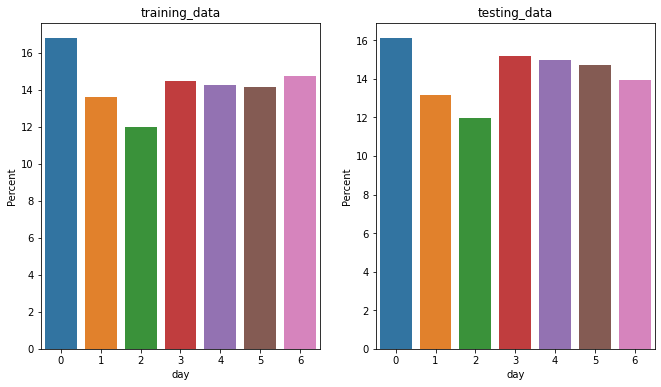

In [260]:
#Check distribution of days
Fn_Plot_Var(training_data,testing_data,'day')

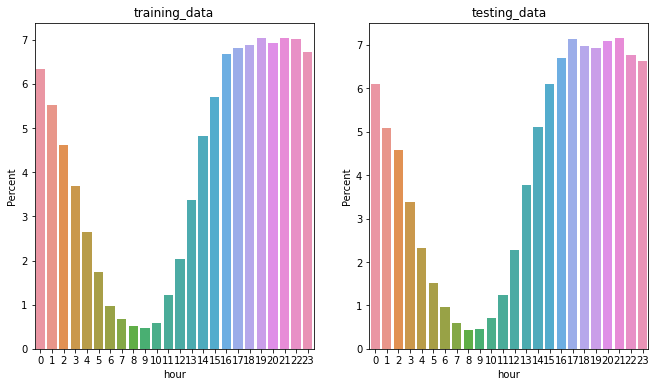

In [261]:
#Check distribution of hours
Fn_Plot_Var(training_data,testing_data,'hour')

In [262]:
gc.collect()

33731

In [263]:
training_data_hour = (training_data.groupby(['isFraud'])['hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('hour'))

<AxesSubplot:xlabel='hour', ylabel='percentage'>

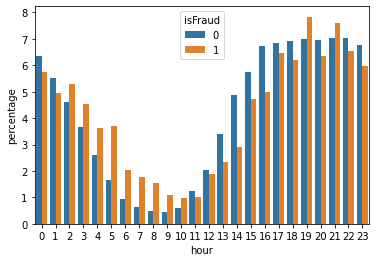

In [264]:
sns.barplot(x="hour", y="percentage", hue="isFraud", data=training_data_hour)

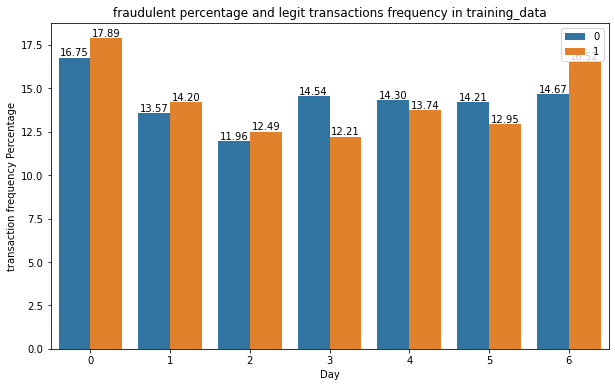

In [265]:
training_data_day = training_data.groupby('isFraud')['day'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('day')
plt.figure(figsize=(10,6))
barplot = sns.barplot(x="day", y="percentage", hue="isFraud", data=training_data_day)
plt.legend()
plt.ylabel('transaction frequency Percentage')
plt.xlabel('Day')
plt.title('fraudulent percentage and legit transactions frequency in training_data')
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
plt.show()

From this plot not many discoveries. Day 0 often sees a higher volume of transactions, both legitimate and fraudulent.

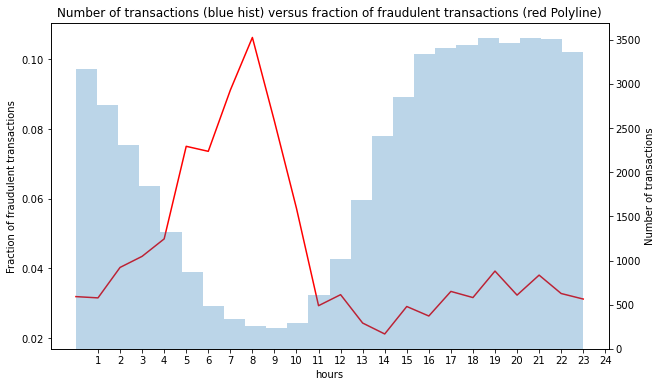

In [266]:
#https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
plt.figure(figsize=(10,6))
plt.plot(training_data.groupby('hour').mean()['isFraud'], color='r')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(training_data['hour'], alpha=0.3, bins=24)
ax.set_xlabel('hours')
ax.set_ylabel('Fraction of fraudulent transactions')
ax2.set_ylabel('Number of transactions')
plt.title('Number of transactions (blue hist) versus fraction of fraudulent transactions (red Polyline)')
plt.xticks(np.arange(1, 25, 1))
plt.show()

From the above graph, it seems that from 3am to 13pm the fraction of fraud is significantly higher than other hours. From 13pm to 15pm, the fractions of fraud is the lowest. While from 6am to 11am the fraction is the highest.  hence we can create a new features based on this.

In [267]:
#Creating new feature
def NewHourFeature(hour):
    if hour>2 and hour < 12:
        return "highalertsign"
    if hour ==13 or hour==15:
        return "lowalertsign"
    if hour==2 or hour==18 or hour==23:
        return "mediumalertsign"
    else:
        return "noalertsign"

In [268]:
training_data['Hour_Alert'] = training_data['hour'].apply(NewHourFeature)
testing_data['Hour_Alert'] = testing_data['hour'].apply(NewHourFeature)

#### Conclusion on TransactionDt

By following some easy math trails, we can deduce that TransactionDT is in seconds.
So that we may examine the time more closely, we can construct new columns such as hour, day, week, and month.
The training_data and testing_data datasets are in different time periods, as shown by the distribution of TransactionDT(bin in minute), therefore dividing the data by the time order can be a fair technique.

From 13 to 15 there are more legal transactions.
It appears that compared to other times, the fraction of fraudulent transactions is much greater between the hours of 3am and 12pm. And the lowest fraud fractions occur between 13:00 and 15:00 PM. While the fraud percentage is at its peak between 6 and 11 am. The ability to categorize time periods into various levels of warning indication based on their fraud fraction allows us to develop yet another new feature.
Since we only have one year's worth of data, we can't model year or month and therefore can't identify any trends. The weekday and hour may be relevant information.

In [269]:
gc.collect()

15019

## TransactionAmt

In [270]:
transactionAmtDescribe = describe_variable(training_data,testing_data,'TransactionAmt')
transactionAmtDescribe

TransactionAmt training_data training_dataFraud training_dataLegit  \
0           count       50000.0             1761.0            48239.0   
1            mean           inf                inf                inf   
2             std           inf                inf                inf   
3             min      0.291992           0.291992           0.687012   
4             25%       43.9375               39.0           43.96875   
5             50%          68.5            77.8125            67.9375   
6             75%    121.953125              171.0              117.0   
7             max        4976.0             2680.0             4976.0   
8          unique          3840                650               3734   
9             NaN             0                  0                  0   
10       NaNshare           0.0                0.0                0.0   

   testing_data  
0       50000.0  
1           inf  
2           inf  
3      0.140015  
4          40.0  
5       67.9375  
6         125.0  
7        9336.0  
8          3238  
9             0  
10          0.0

The maximum training_data transactionAmt value is lower than the testing_data transactionAmt.

#### Outlier check for the columns analysed so far

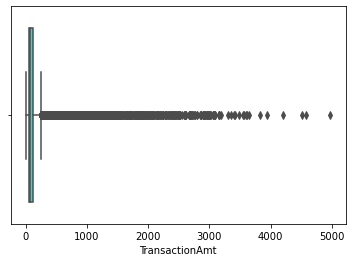

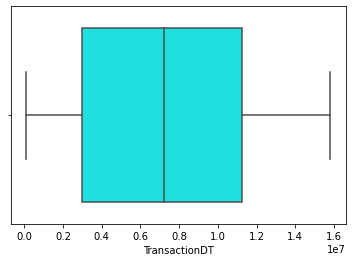

In [271]:
num_col = ['TransactionAmt','TransactionDT']
for col in num_col:
    sns.boxplot(data = training_data[col] , x=training_data[col] , color='cyan')
    plt.show()

There are outliers with the transaction amount above 3000, this can be removed to avoid overfitting

In [272]:
#Removing values more than 3,000
training_data = training_data[training_data['TransactionAmt']<3000]

In [273]:
training_data['LogTransactionAmt'] = np.log(training_data['TransactionAmt'])
testing_data['LogTransactionAmt'] = np.log(testing_data['TransactionAmt'])

<AxesSubplot:title={'center':'testing_data'}, xlabel='LogTransactionAmt', ylabel='Density'>

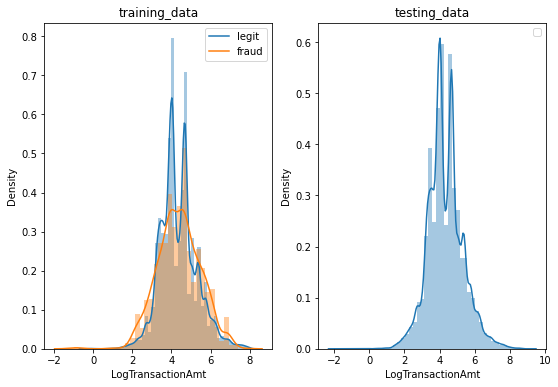

In [274]:
#taking log for better visualization
plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
sns.distplot(training_data[training_data['isFraud']==0]['LogTransactionAmt'])
sns.distplot(training_data[training_data['isFraud']==1]['LogTransactionAmt'])
plt.title('training_data')
plt.legend(['legit','fraud'])
plt.subplot(1,2,2)
plt.legend(['legit','fraud'])
plt.title('testing_data')
sns.distplot(testing_data['LogTransactionAmt'])


In [275]:
gc.collect()

6411

## dist1 and dist2

In [276]:
describe_variable(training_data,testing_data,'dist1')

dist1 training_data training_dataFraud training_dataLegit testing_data
0      count       20307.0              426.0            19881.0      21239.0
1       mean           inf                inf                inf          inf
2        std           inf                inf                inf          inf
3        min           0.0                0.0                0.0          0.0
4        25%           3.0                4.0                3.0          3.0
5        50%           8.0               10.0                8.0          8.0
6        75%          24.0               85.5               24.0         20.0
7        max       10288.0             2456.0            10288.0       5000.0
8     unique          1310                135               1287         1048
9        NaN         29660               1335              28325        28761
10  NaNshare      0.593592           0.758092           0.587582      0.57522

max value in dist1 fraud training data is lesser than training Legit

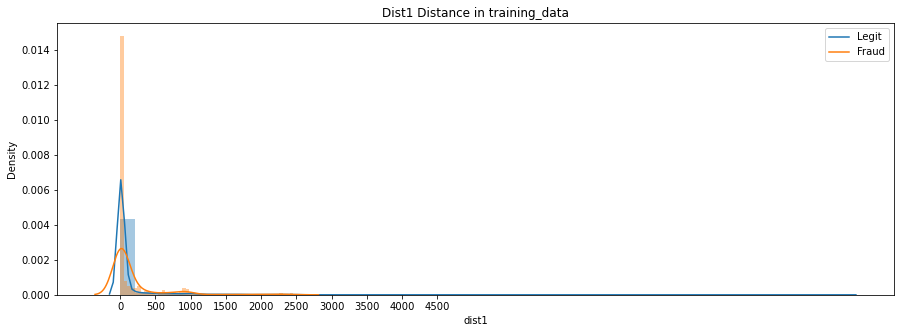

In [277]:
#checking distribution of dist1 variable
plt.figure(figsize=(15,5))
sns.distplot(training_data[(training_data['isFraud']==0) & (~training_data['dist1'].isnull())]['dist1'])
sns.distplot(training_data[(training_data['isFraud']==1) & (~training_data['dist1'].isnull())]['dist1'])
plt.legend(['Legit','Fraud'])
plt.xticks(np.arange(0,5000,500))
plt.title('Dist1 Distance in training_data')
plt.show()

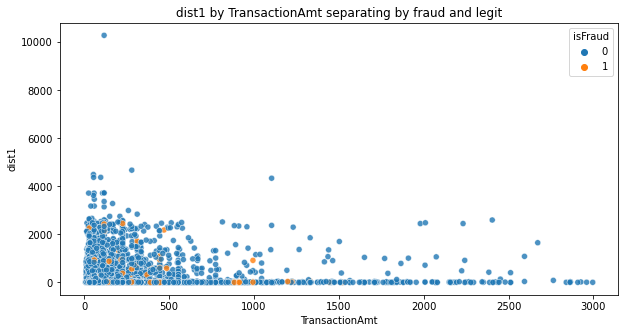

In [278]:
plt.figure(figsize=(10,5))
sns.scatterplot(x="TransactionAmt",y="dist1",hue="isFraud",data=training_data[~training_data['dist1'].isnull()], alpha=0.8, hue_order=[0,1])
plt.title('dist1 by TransactionAmt separating by fraud and legit')
plt.show()

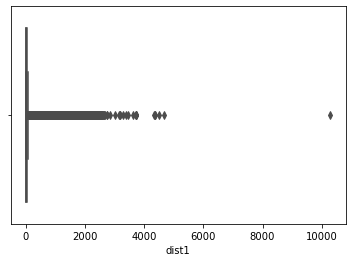

In [279]:
sns.boxplot(data = training_data['dist1'] , x=training_data['dist1'] , color='cyan')
plt.show()

values dist1 > 3000 in training_data are outliers.

In [280]:
training_data.drop(training_data[training_data.dist1>3000].index, axis=0, inplace=True)

In [281]:
describe_variable(training_data,testing_data,'dist2')

dist2 training_data training_dataFraud training_dataLegit testing_data
0      count        3063.0              298.0             2765.0       3569.0
1       mean           inf             217.25                inf          inf
2        std           inf                inf                inf          inf
3        min           0.0                0.0                0.0          0.0
4        25%           7.0                7.0                7.0          7.0
5        50%          44.0               25.0               46.0         46.0
6        75%         218.0              218.0              218.0        202.0
7        max        7380.0             5928.0             7380.0       9216.0
8     unique           626                114                597          701
9        NaN         46886               1463              45423        46431
10  NaNshare      0.938677           0.830778           0.942621      0.92862

Around 90 percentage of missing values

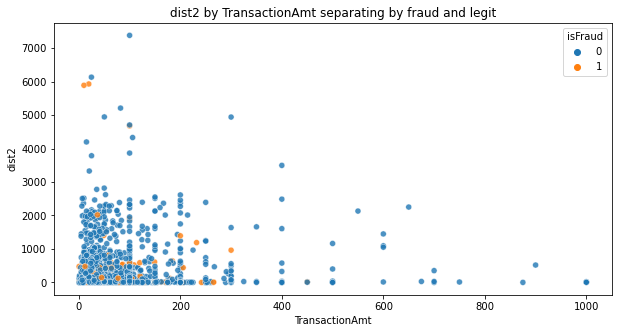

In [282]:
plt.figure(figsize=(10,5))
sns.scatterplot(x="TransactionAmt",y="dist2",hue="isFraud",data=training_data[~training_data['dist2'].isnull()],alpha=0.8,hue_order=[0,1])
plt.title('dist2 by TransactionAmt separating by fraud and legit')
plt.show()

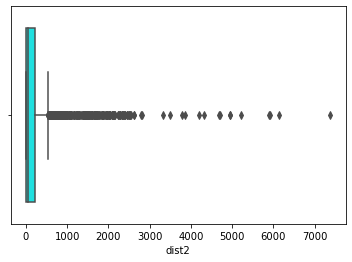

In [283]:
sns.boxplot(data = training_data['dist2'] , x=training_data['dist2'] , color='cyan')
plt.show()

values dist1 > 3000 in training_data are outliers.

In [284]:
gc.collect()

22818

## C1-C14

In [285]:
#Subset variables C1 to C14
C_cols  = training_data[['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]

In [286]:
for col in C_cols:
    print(col, 'unique values in this column are --->', training_data[col].nunique())
    print('C1', 'Null values in this column are --->', training_data['C1'].isnull().sum())
    print(describe_variable(training_data,testing_data,col))
    print()

C1 unique values in this column are ---> 437
C1 Null values in this column are ---> 0
          C1 training_data training_dataFraud training_dataLegit testing_data
0      count       49949.0             1761.0            48188.0      50000.0
1       mean           inf           32.84375                inf          inf
2        std           inf                inf                inf          inf
3        min           0.0                0.0                0.0          0.0
4        25%           1.0                1.0                1.0          1.0
5        50%           1.0                2.0                1.0          1.0
6        75%           3.0                6.0                3.0          3.0
7        max        4616.0             4616.0             4540.0       2946.0
8     unique           437                142                414          407
9        NaN             0                  0                  0            0
10  NaNshare           0.0                0.0           

          C9 training_data training_dataFraud training_dataLegit testing_data
0      count       49949.0             1761.0            48188.0      50000.0
1       mean           inf           1.603516                inf          inf
2        std     17.015625           8.476562          17.234375          inf
3        min           0.0                0.0                0.0          0.0
4        25%           0.0                0.0                0.0          0.0
5        50%           1.0                0.0                1.0          1.0
6        75%           2.0                1.0                2.0          2.0
7        max         203.0              132.0              203.0        567.0
8     unique           176                 29                175          205
9        NaN             0                  0                  0            0
10  NaNshare           0.0                0.0                0.0          0.0

C10 unique values in this column are ---> 265
C1 Null values in

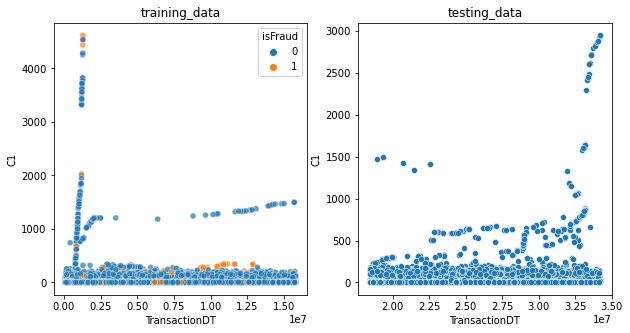

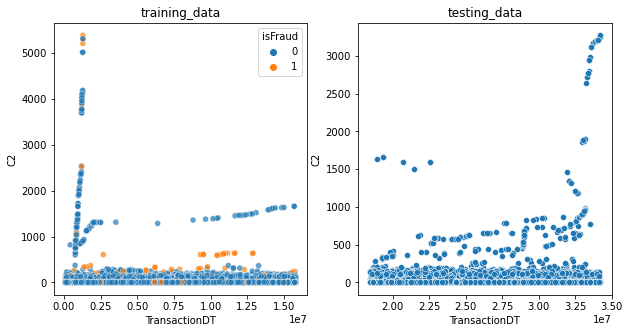

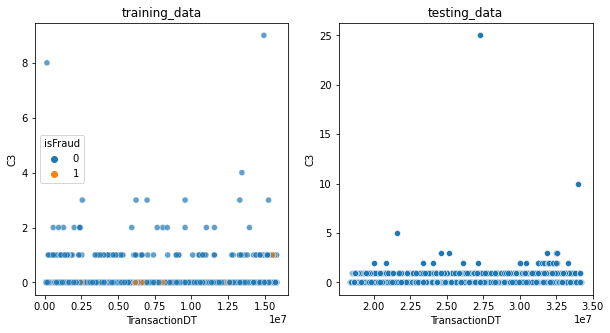

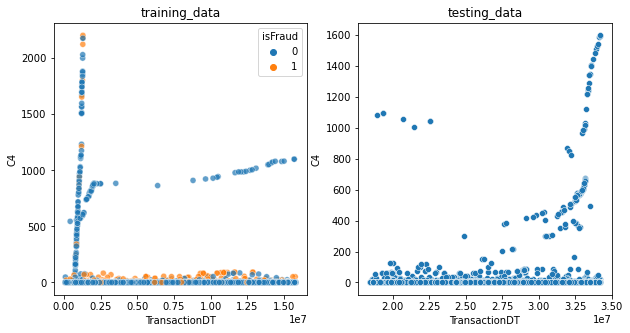

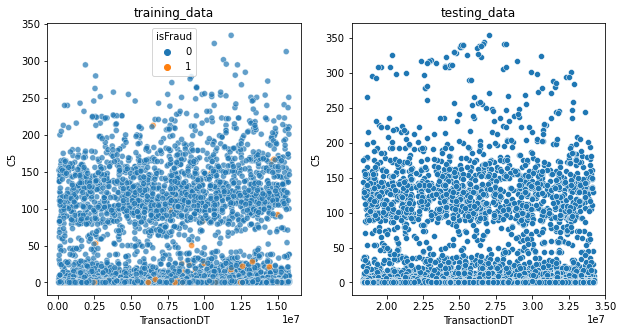

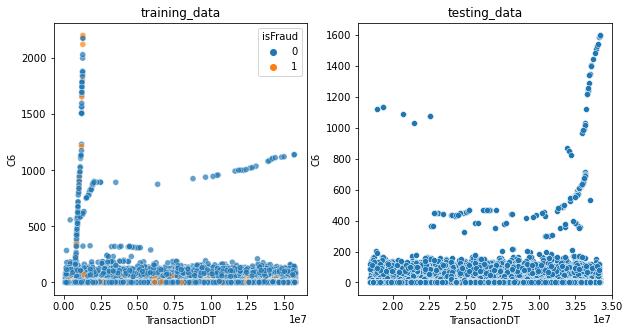

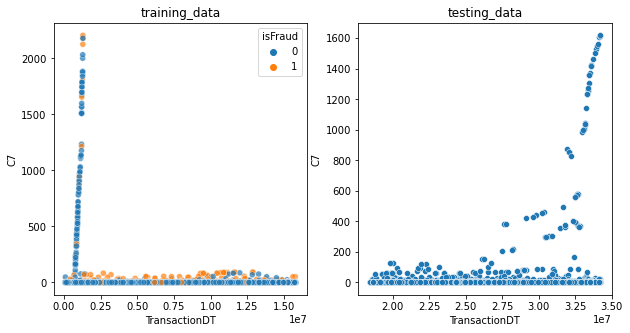

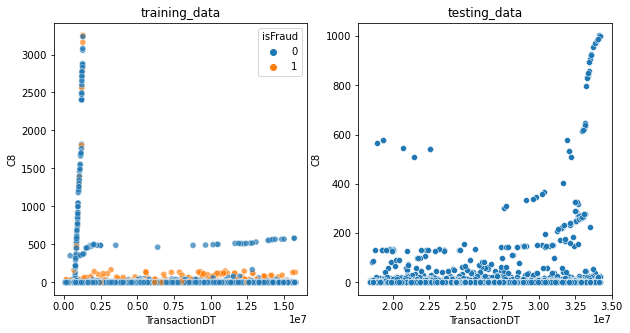

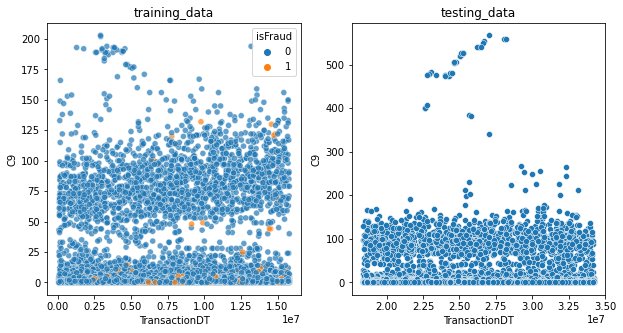

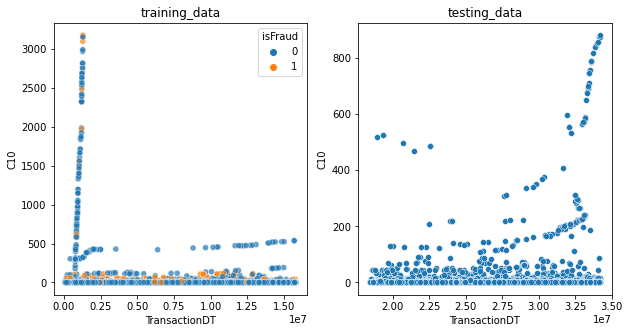

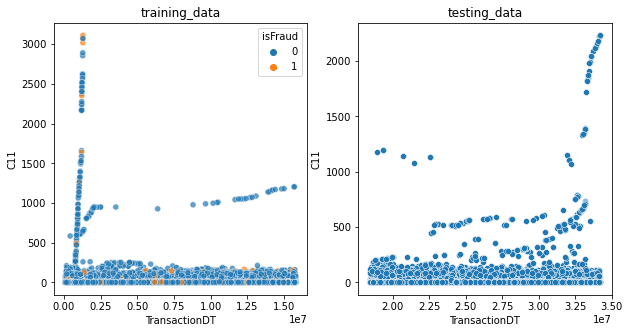

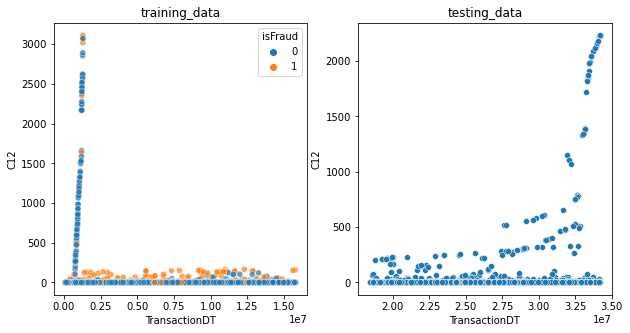

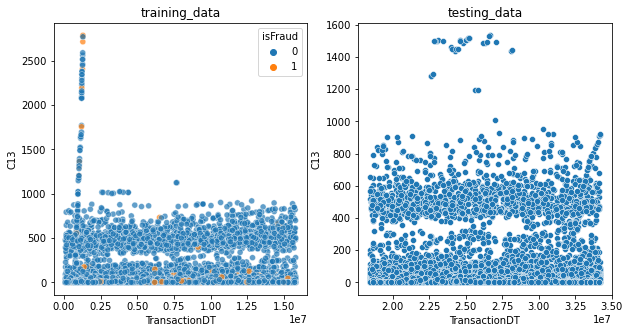

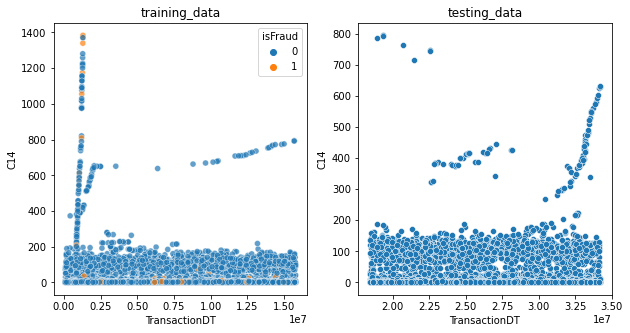

In [287]:
for col in C_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=training_data,alpha=0.7,hue_order=[0,1])
    plt.title('training_data')
    plt.subplot(1,2,2)
    sns.scatterplot(x="TransactionDT",y=col,data=testing_data[~testing_data[col].isnull()])
    plt.title('testing_data')

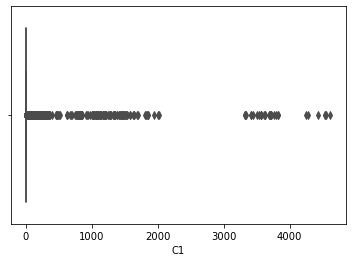

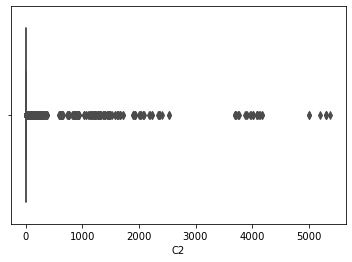

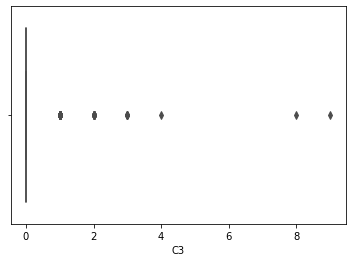

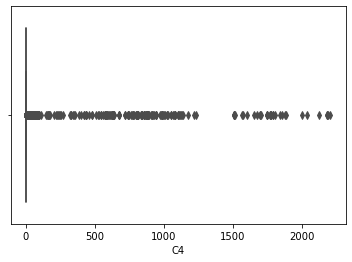

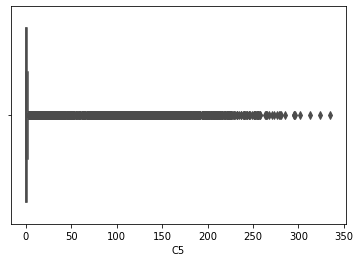

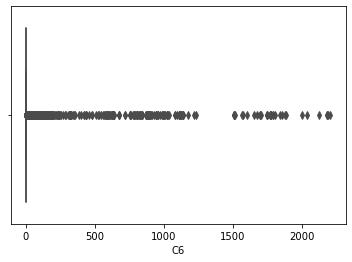

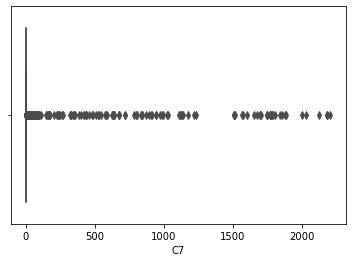

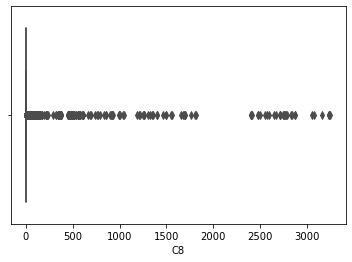

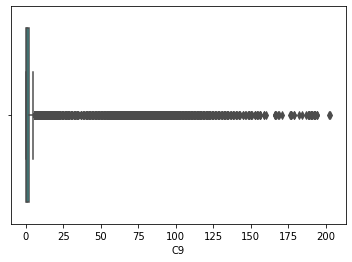

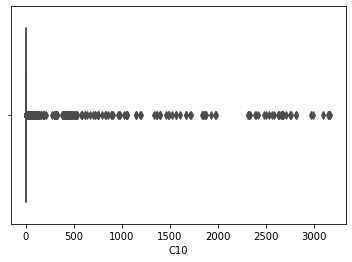

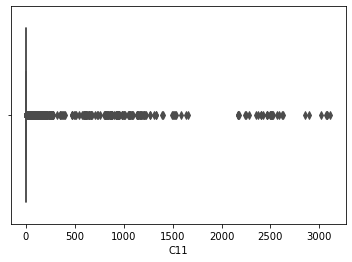

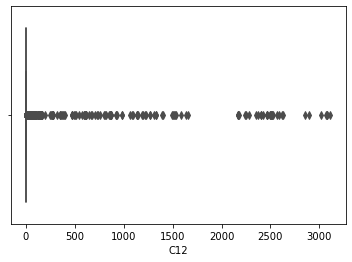

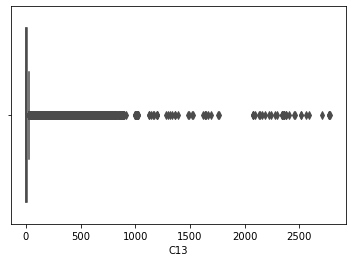

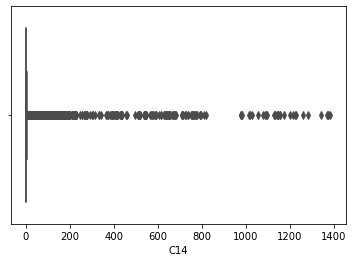

In [288]:
for col in C_cols:
    sns.boxplot(data = training_data[col] , x=training_data[col] , color='cyan')
    plt.show()

There are no outliers in C5 and C9 whereas other variables are having extreme outliers

Removing outliers in C features

In [289]:
training_data.drop(training_data[training_data.C1>2000].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C2>3000].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C3>1500].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C4>1500].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C6>1400].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C7>1400].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C8>2000].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C10>2000].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C11>2000].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C12>1700].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C13>1500].index, axis=0, inplace=True)
training_data.drop(training_data[training_data.C14>800].index, axis=0, inplace=True)

Except for C13, C features have no missing values in training_data and 3 NaN in testing_data.

In [290]:
gc.collect()

133920

## D1-D15

In [291]:
#Subset variables D1 to D15
D_cols  = training_data[['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']]

In [292]:
for col in D_cols:
    print(col, 'unique values in this column are --->', training_data[col].nunique())
    print(col, 'Null values in this column are --->', training_data[col].isnull().sum())
    print(describe_variable(training_data,testing_data,col))
    print()

D1 unique values in this column are ---> 640
D1 Null values in this column are ---> 118
          D1 training_data training_dataFraud training_dataLegit testing_data
0      count       49788.0             1752.0            48036.0      49424.0
1       mean           inf                inf                inf          inf
2        std           inf                inf                inf          inf
3        min           0.0                0.0                0.0          0.0
4        25%           0.0                0.0                0.0          0.0
5        50%           3.0                0.0                4.0          5.0
6        75%         121.0               14.0              126.0        149.0
7        max         639.0              636.0              639.0        640.0
8     unique           641                237                641          642
9        NaN           118                  2                116          576
10  NaNshare      0.002364            0.00114         

          D9 training_data training_dataFraud training_dataLegit testing_data
0      count        6355.0              641.0             5714.0       7344.0
1       mean        0.5625           0.511719           0.567383     0.552734
2        std      0.315186           0.332764             0.3125     0.318848
3        min           0.0                0.0                0.0          0.0
4        25%      0.208374           0.166626           0.208374     0.208374
5        50%      0.666504              0.625           0.666504     0.666504
6        75%      0.833496           0.791504           0.833496     0.791504
7        max      0.958496           0.958496           0.958496     0.958496
8     unique            25                 25                 25           25
9        NaN         43551               1113              42438        42656
10  NaNshare      0.872661            0.63455           0.881334      0.85312

D10 unique values in this column are ---> 694
D10 Null values i

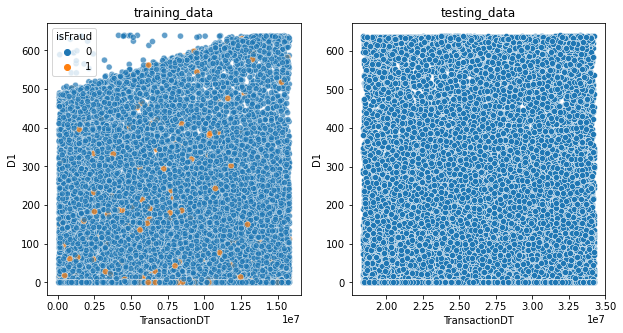

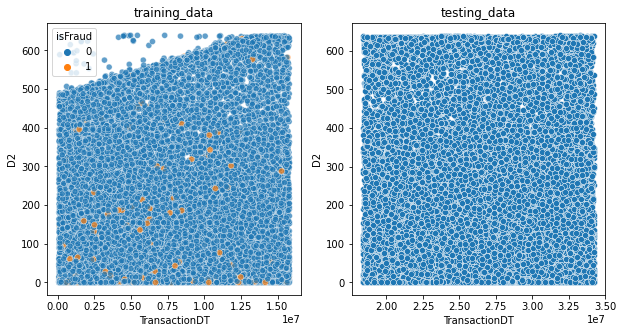

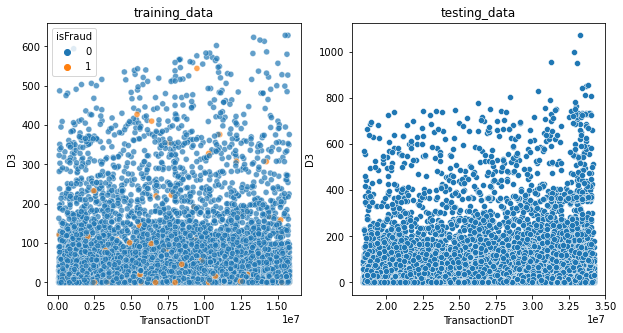

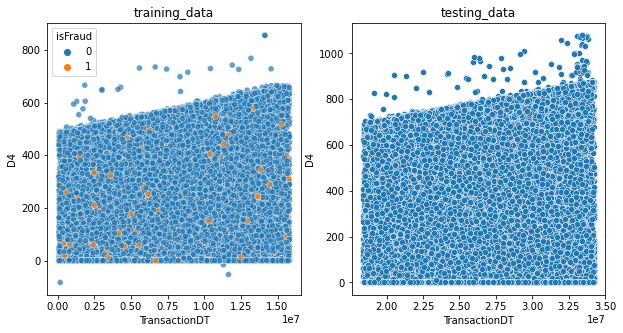

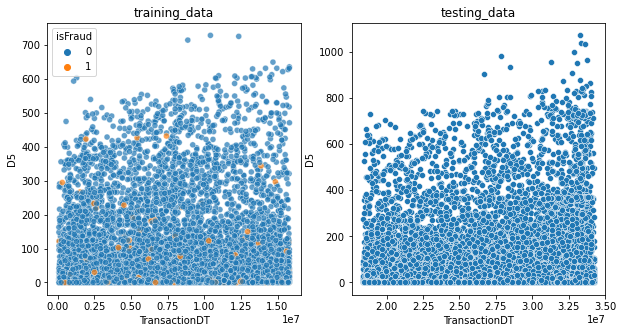

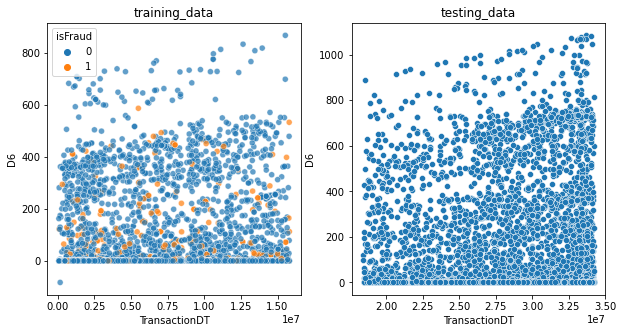

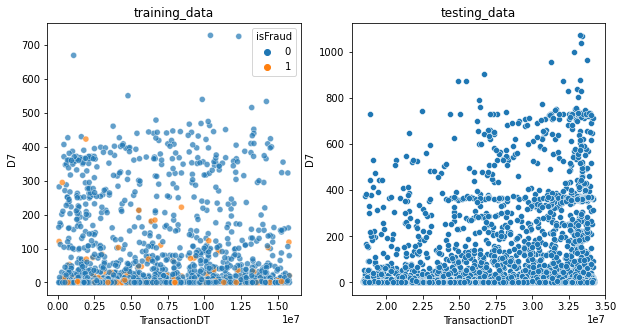

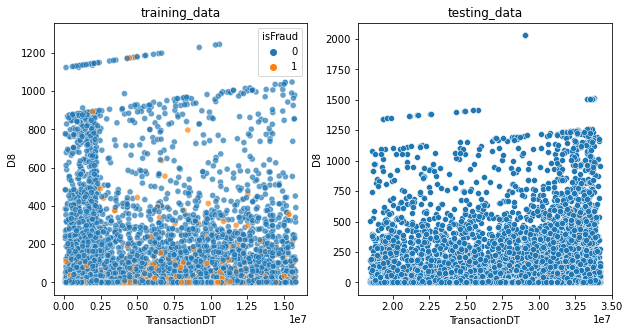

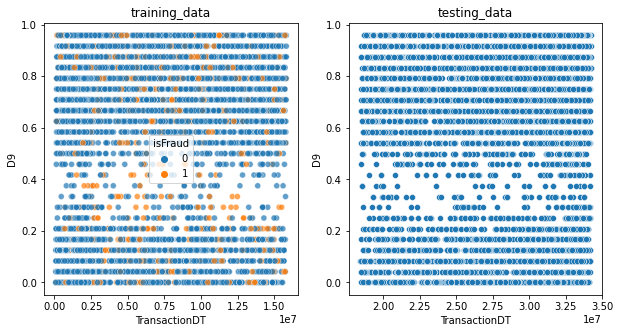

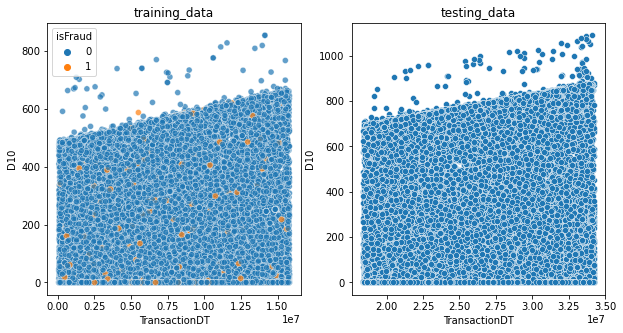

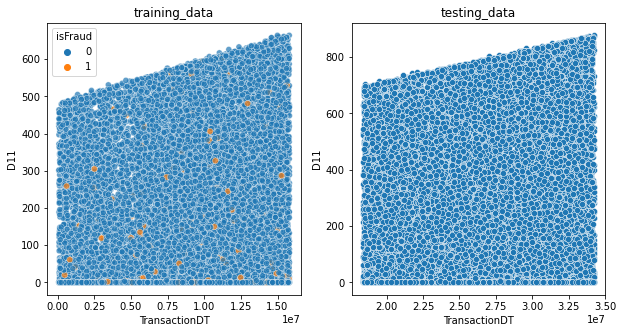

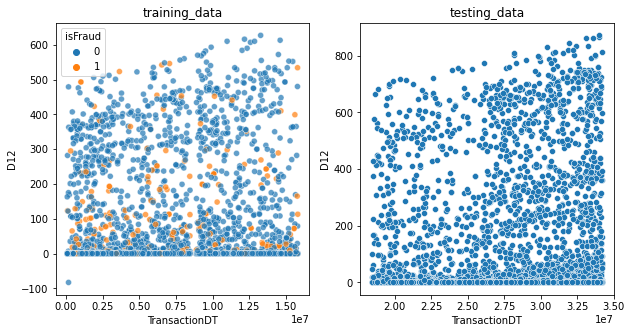

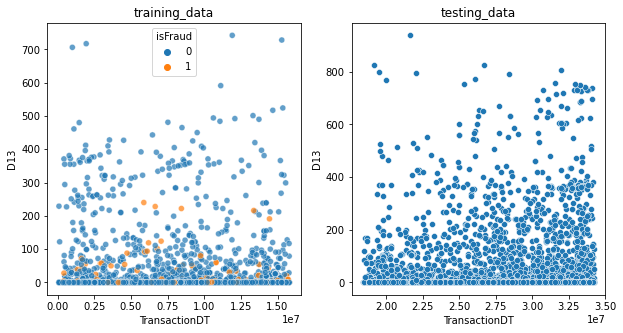

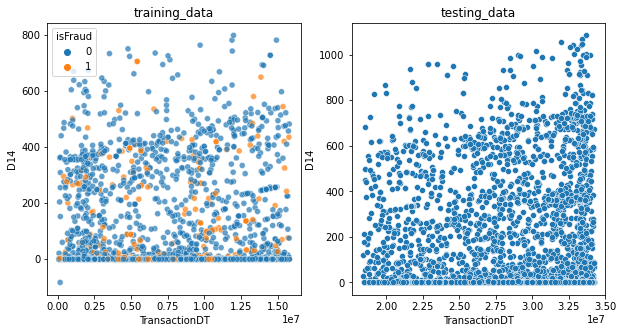

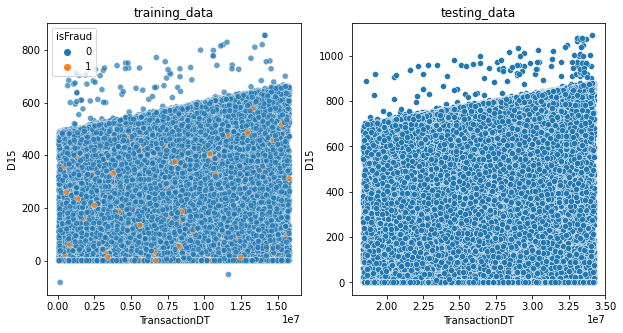

In [293]:
for col in D_cols:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.scatterplot(x="TransactionDT",y=col,hue="isFraud",data=training_data,alpha=0.7,hue_order=[0,1])
    plt.title('training_data')
    plt.subplot(1,2,2)
    sns.scatterplot(x="TransactionDT",y=col,data=testing_data[~testing_data[col].isnull()])
    plt.title('testing_data')

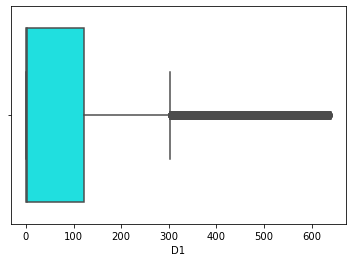

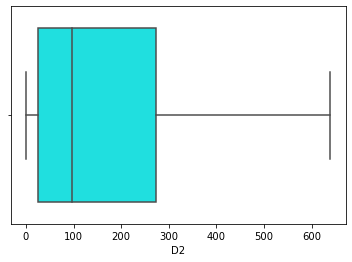

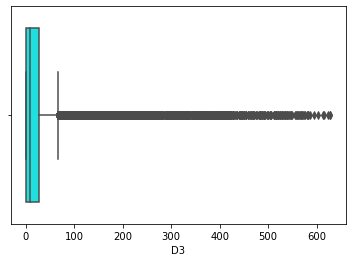

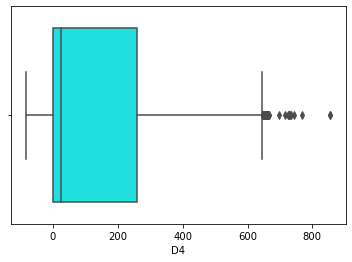

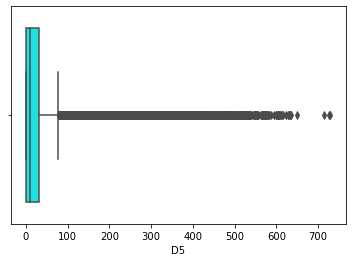

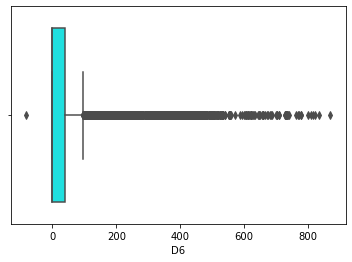

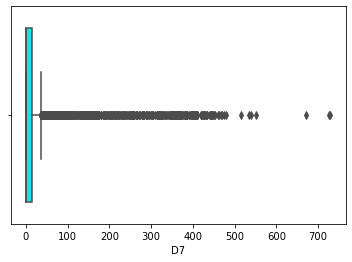

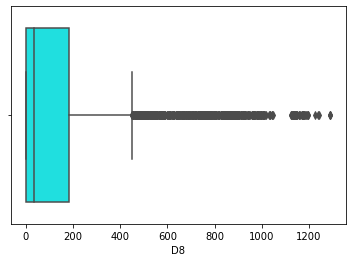

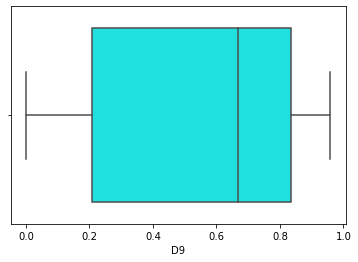

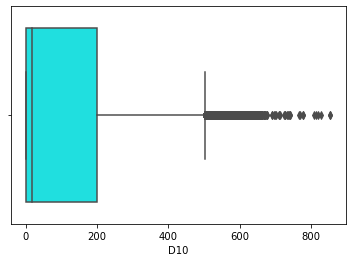

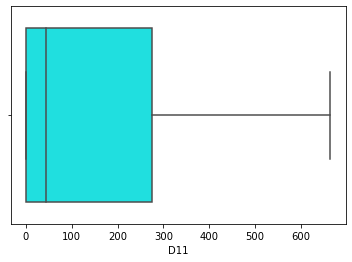

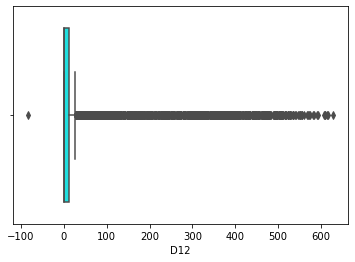

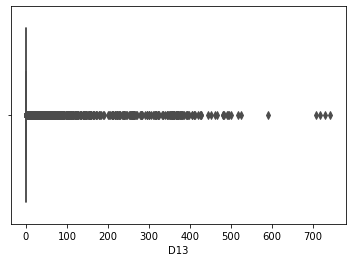

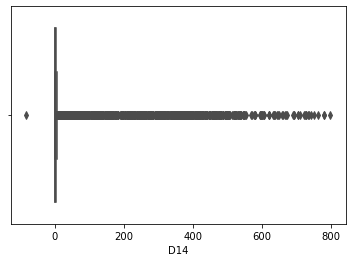

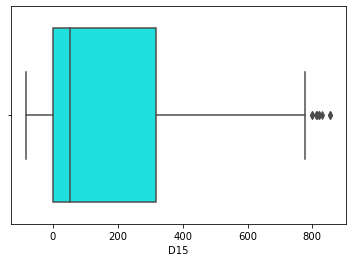

In [294]:
for col in D_cols:
    sns.boxplot(data = training_data[col] , x=training_data[col] , color='cyan')
    plt.show()

The majority of D variables are monotonically growing with TransactionDT, this make sense given as these variables are  timedelta characteristics.

In [295]:
gc.collect()

142661

## V1 - V339

with Initial EDA most of the v variables did not show up unique importance, hence i will analyze these variables after feature importance

## id01-id11

In [296]:
#Subset variables iD1 to iD11
ID_cols  = training_data[['id_01','id_02','id_03','id_04','id_05','id_06','id_07','id_08','id_09','id_10','id_11']]

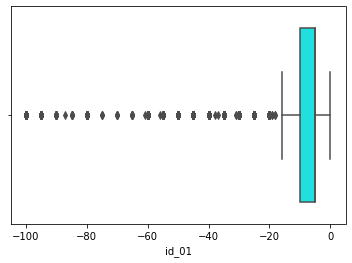

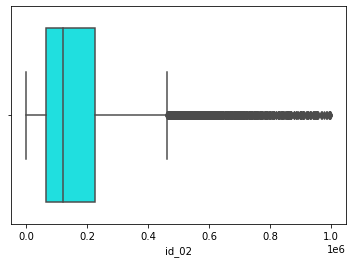

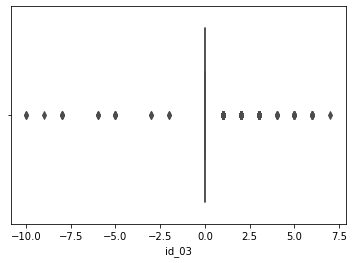

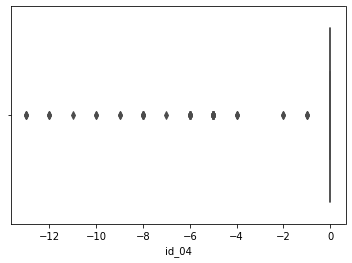

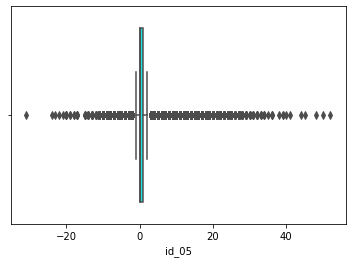

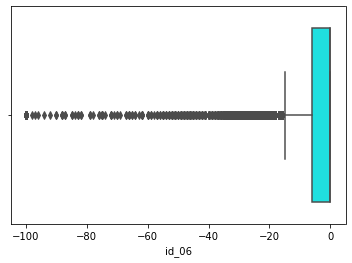

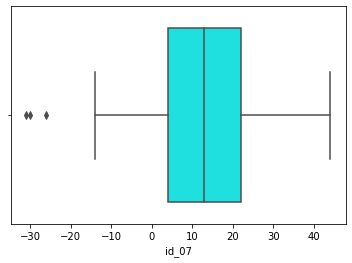

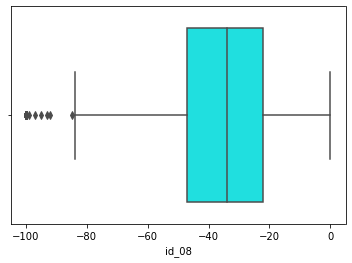

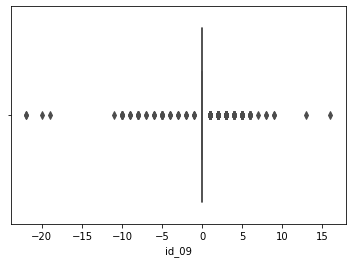

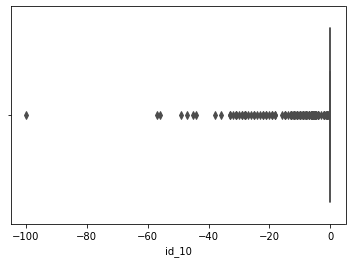

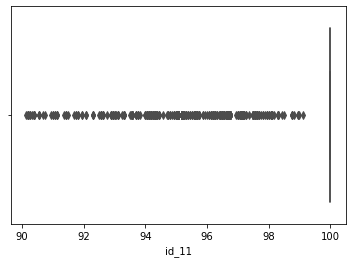

In [297]:
for col in ID_cols:
    sns.boxplot(data = training_data[col] , x=training_data[col] , color='cyan')
    plt.show()

## Categorical Variables

In [298]:
#writing a function to plot categorical variables
def Plot_For_Cat_Var(variable, datafrm=training_data):
    training_data[variable].fillna("NA", inplace=True)
    variable_fraud_rate = datafrm.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    plt.figure(figsize=(10,5))
    g = sns.countplot(x = variable, data = datafrm, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")
    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "red")
    r.set_ylabel("Fraud Rate", fontsize = 15, color = "red")

## ProductCD

<AxesSubplot:xlabel='ProductCD', ylabel='percentage'>

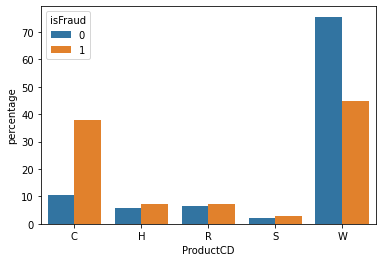

In [299]:
training_data_ProductCD = (training_data.groupby(['isFraud'])['ProductCD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('ProductCD'))
sns.barplot(x="ProductCD", y="percentage", hue="isFraud", data=training_data_ProductCD)

The plot makes it apparent that there is a 40% possibility of fraud if ProductCD receives a "C."
It is evident that there is a significant percentage of fraud in R, H, S and in W legit count is high

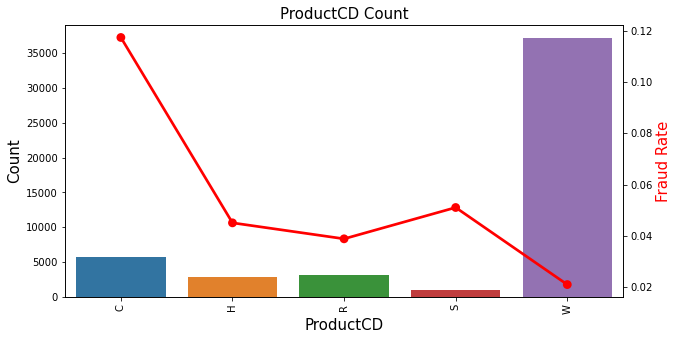

In [300]:
Plot_For_Cat_Var('ProductCD')

In [301]:
gc.collect()

40027

## card1 - card6

In [302]:
#Function to Plot Card variables
def Plot_Card_Var(training_data, testing_data,col):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.distplot(training_data[training_data['isFraud']==0][col])
    sns.distplot(training_data[training_data['isFraud']==1][col])
    plt.legend(['legit','fraud'])
    plt.title('training_data')
    plt.subplot(1,2,2)
    sns.distplot(testing_data[col])
    plt.title('testing_data')

## card1

In [303]:
card1Desc = describe_variable(training_data,testing_data,'card1')
card1Desc

card1 training_data training_dataFraud training_dataLegit testing_data
0      count       49906.0             1754.0            48152.0      50000.0
1       mean   9880.081874        9424.568415        9896.674551    9959.5526
2        std   4894.737159        4664.895924        4902.153365  4885.686241
3        min        1001.0             1030.0             1001.0       1006.0
4        25%        6019.0             5649.5             6019.0       6019.0
5        50%        9633.0             9633.0             9633.0       9803.0
6        75%       14165.0            13276.0            14191.0      14276.0
7        max       18390.0            18370.0            18390.0      18395.0
8     unique          5688                513               5606         5748
9        NaN             0                  0                  0            0
10  NaNshare           0.0                0.0                0.0          0.0

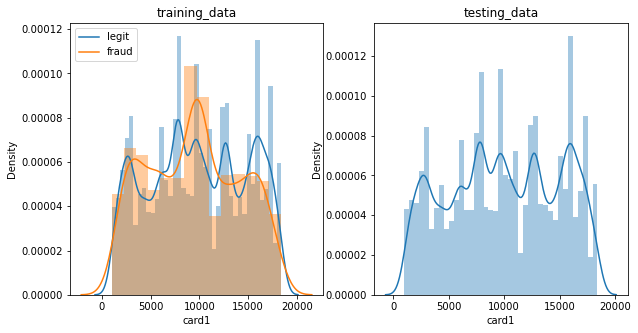

In [304]:
Plot_Card_Var(training_data, testing_data,'card1')

## card2

In [305]:
card2Desc = describe_variable(training_data,testing_data,'card2')
card2Desc

card2 training_data training_dataFraud training_dataLegit testing_data
0      count       49129.0             1725.0            47404.0      49130.0
1       mean           inf                inf                inf          inf
2        std           inf                inf                inf          inf
3        min         100.0              100.0              100.0        100.0
4        25%         209.0              203.0              210.0        206.0
5        50%         361.0              375.0              361.0        361.0
6        75%         512.0              514.0              512.0        512.0
7        max         600.0              595.0              600.0        600.0
8     unique           499                160                499          497
9        NaN           777                 29                748          870
10  NaNshare      0.015569           0.016534           0.015534       0.0174

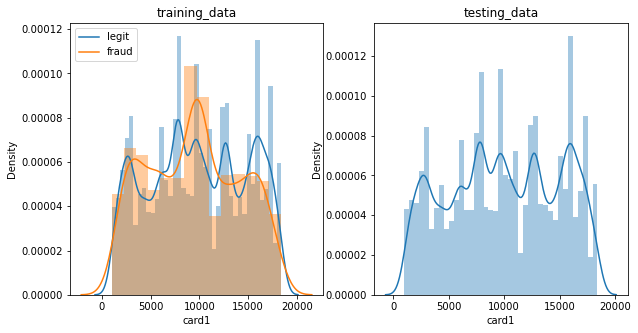

In [306]:
Plot_Card_Var(training_data, testing_data,'card1')

## card3

In [307]:
card3Desc = describe_variable(training_data,testing_data,'card3')
card3Desc

card3 training_data training_dataFraud training_dataLegit testing_data
0      count       49794.0             1754.0            48040.0      49704.0
1       mean           inf                inf                inf          inf
2        std         11.25           17.21875          10.820312     12.46875
3        min         100.0              100.0              100.0        100.0
4        25%         150.0              150.0              150.0        150.0
5        50%         150.0              150.0              150.0        150.0
6        75%         150.0              185.0              150.0        150.0
7        max         231.0              214.0              231.0        232.0
8     unique            62                 18                 61           77
9        NaN           112                  0                112          296
10  NaNshare      0.002244                0.0           0.002326      0.00592

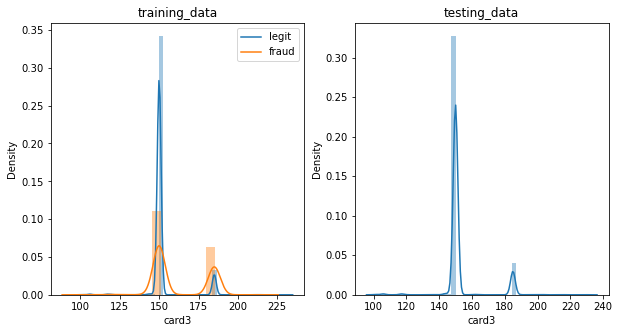

In [308]:
Plot_Card_Var(training_data, testing_data,'card3')

It can be seen that card 3 only has the majority of the two values.
Additionally, the description function discovered that if the value is higher than 140, there is a higher chance that the transaction is fraudulent.
We can add another variable, such as marking something as T (meaning fraud) if the amount is higher than 140, otherwise F.

In [309]:
def card3Values(val):
    if val==np.nan:
        return val
    else:
        if val > 140:
            return 'T'
        else:
            return 'F'

In [310]:
training_data['card3Values'] = training_data['card3'].apply(card3Values)
testing_data['card3Values'] = testing_data['card3'].apply(card3Values)

## card4

Text(0.5, 1.0, 'training_data')

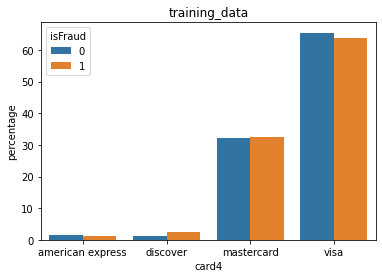

In [311]:
training_data_card4 = (training_data[~training_data['card4'].isnull()].groupby(['isFraud'])['card4']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('card4'))
sns.barplot(x="card4", y="percentage", hue="isFraud", data=training_data_card4)
plt.title('training_data')

The majority of transactions used visa cards. One finding is that more card discover usage occurs in fraudulent transactions than in legitimate ones. If not, other cards often have the same frequency.

## card6

Text(0.5, 1.0, 'testing_data')

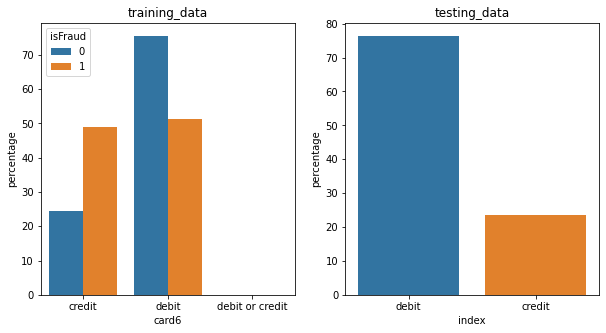

In [312]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
training_data_card6 = (training_data[~training_data['card6'].isnull()].groupby(['isFraud'])['card6']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('card6'))
sns.barplot(x="card6", y="percentage", hue="isFraud", data=training_data_card6)
plt.title('training_data')
plt.subplot(1,2,2)
testing_data_card6 =testing_data[~testing_data['card6'].isnull()]['card6'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="index", y="percentage", data=testing_data_card6)
plt.title('testing_data')

In [313]:
print('%d observations are charge card' % training_data[training_data['card6']=='charge card'].shape[0])
print('%d observations are "debit or credit" card' % training_data[training_data['card6']=='debit or credit'].shape[0])

0 observations are charge card
5 observations are "debit or credit" card


Nearly 0% of the dataset's transactions are happening in 'debit or credit'and 'charge cards'.<br>
People who use credit cards typically experience more fraud than people who use debit cards.<br>
As there are no transactions happening in these cards we can group them with debit card

In [314]:
def replacecard6(value):
    if value==np.nan:
        return value
    if value=='debit or credit' or value=='charge card':
        return 'debit'
    else:
        return value

In [315]:
training_data['card6'] = training_data['card6'].apply(replacecard6)
testing_data['card6'] = testing_data['card6'].apply(replacecard6)

In [316]:
gc.collect()

36725

## addr1 and addr2

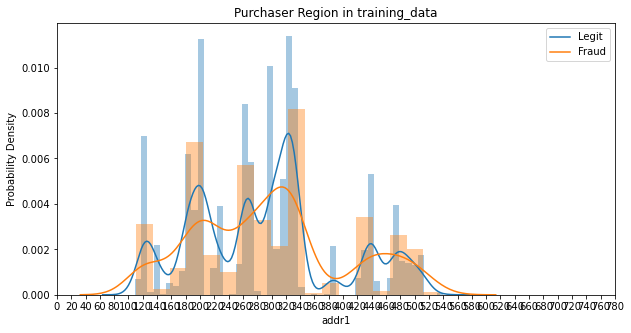

In [317]:
plt.figure(figsize=(10,5))
sns.distplot(training_data[(training_data['isFraud']==0) & (~training_data['addr1'].isnull())]['addr1'])
sns.distplot(training_data[(training_data['isFraud']==1) & (~training_data['addr1'].isnull())]['addr1'])
plt.legend(['Legit','Fraud'])
plt.xticks(np.arange(0, 800, 20))
plt.ylabel('Probability Density')
plt.title('Purchaser Region in training_data')
plt.show()

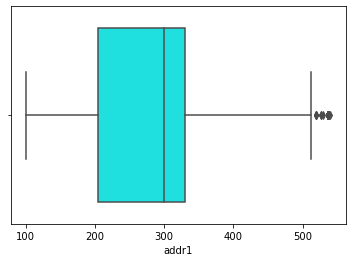

In [318]:
sns.boxplot(data = training_data['addr1'] , x=training_data['addr1'] , color='cyan')
plt.show()

In [319]:
print('There are %d regions in addr1 of training_data' % len(training_data['addr1'].value_counts()))
print(training_data['addr1'].value_counts().head(5))
print('There are %d regions in addr1 of testing_data' % len(testing_data['addr1'].value_counts()))
print(testing_data['addr1'].value_counts().head(5))

There are 133 regions in addr1 of training_data
299.0    3902
204.0    3608
325.0    3542
264.0    3268
330.0    2274
Name: addr1, dtype: int64
There are 139 regions in addr1 of testing_data
299.0    3714
325.0    3499
204.0    3406
264.0    3245
330.0    2173
Name: addr1, dtype: int64


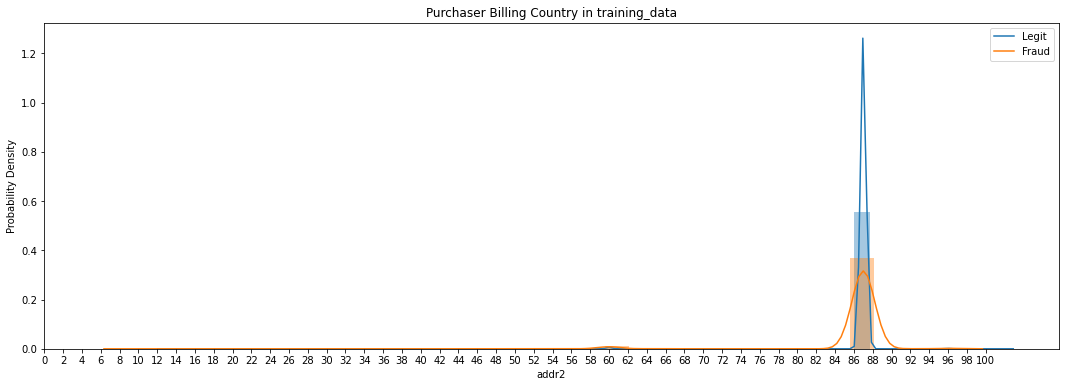

In [320]:
plt.figure(figsize=(40,6))
plt.subplot(1,2,1)
sns.distplot(training_data[(training_data['isFraud']==0) & (~training_data['addr2'].isnull())]['addr2'])
sns.distplot(training_data[(training_data['isFraud']==1) & (~training_data['addr2'].isnull())]['addr2'])
plt.legend(['Legit','Fraud'])
plt.ylabel('Probability Density')
plt.xticks(np.arange(0, 102, 2))
plt.title('Purchaser Billing Country in training_data')
plt.show()

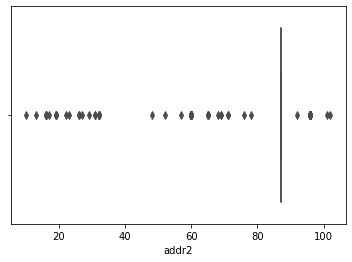

In [321]:
sns.boxplot(data = training_data['addr2'] , x=training_data['addr2'] , color='cyan')
plt.show()

There is not much information in addr2 Except 87, 60 and 96

In [322]:
print('There are %d billing countries in addr2 of training_data.The country 87 accounts for %.2f%%' % (len(training_data['addr2'].value_counts()), training_data['addr2'].value_counts().values[0] / len(training_data['addr2'])*100))
print(training_data['addr2'].value_counts().head(5))
print('There are %d billing countries in addr2 of testing_data. The country 87 accounts for  %.2f%%' % (len(testing_data['addr2'].value_counts()), testing_data['addr2'].value_counts().values[0] / len(testing_data['addr2'])*100))
print(testing_data['addr2'].value_counts().head(5))

There are 27 billing countries in addr2 of training_data.The country 87 accounts for 88.37%
87.0    44103
60.0      273
96.0       50
32.0        7
65.0        6
Name: addr2, dtype: int64
There are 33 billing countries in addr2 of testing_data. The country 87 accounts for  85.98%
87.0    42988
60.0      384
96.0       61
65.0        7
69.0        3
Name: addr2, dtype: int64


There are a total of 29 billing nations in training data and 25 billing countries in testing data. In this country, transactions account for almost 87 percent of all transactions. The majority of buyer billing is considered to originate from the USA(87).

In [323]:
gc.collect()

27416

## P_emaildomain and R_emaildomain

### Purchaser email

In [324]:
#Check count of email domain
training_data['P_emaildomain'].value_counts()[:25]

gmail.com         19481
yahoo.com          8483
hotmail.com        3787
anonymous.com      3165
aol.com            2407
comcast.net         642
icloud.com          541
outlook.com         387
att.net             334
msn.com             322
live.com            273
verizon.net         247
sbcglobal.net       227
ymail.com           182
bellsouth.net       163
yahoo.com.mx        132
me.com              120
cox.net             117
charter.net          83
optonline.net        79
live.com.mx          59
rocketmail.com       47
gmail                46
mail.com             46
earthlink.net        44
Name: P_emaildomain, dtype: int64

In [325]:
#Create parent emaildomain
training_data["P_parent_emaildomain"] = training_data["P_emaildomain"].str.split('.', expand = True)[[0]]

In [326]:
email_columns = ['P_parent_emaildomain','P_emaildomain']

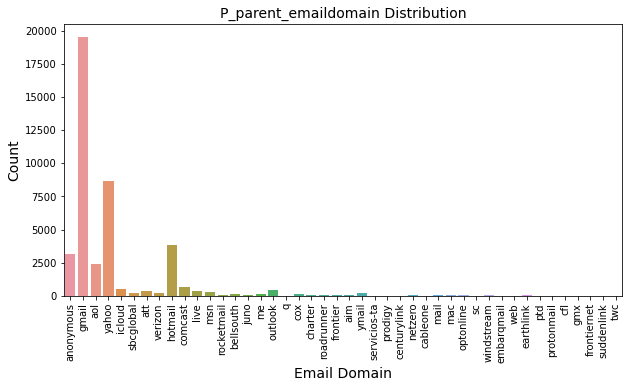

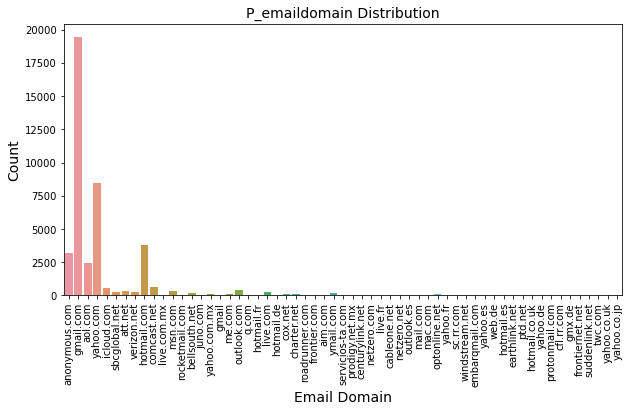

In [327]:
#Purchaser Email Domain Distribution
for col in email_columns:
    plt.figure(figsize=(10,5))
    g = sns.countplot(x = training_data[col], data = training_data)
    g.set_title(col + ' Distribution', fontsize = 14)
    g.set_xlabel("Email Domain", fontsize=14)
    g.set_ylabel("Count", fontsize=14)
    plt.xticks(rotation='vertical')

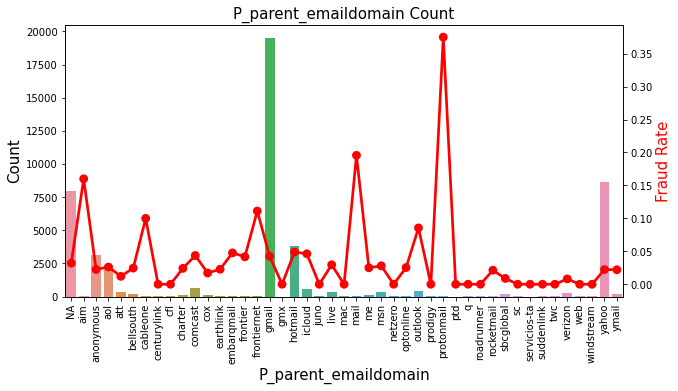

In [328]:
Plot_For_Cat_Var('P_parent_emaildomain')

while highest emails are sent by gmail and yahoo, Extremely high fraud rates are reported by proton mail. Highest purchases is made through protonmail.com involved label fraud.

In [329]:
protonmail_fraud = len(training_data[(training_data['P_parent_emaildomain'] == "protonmail") & (training_data['isFraud'] == 1)])
protonmail_non_fraud = len(training_data[(training_data['P_parent_emaildomain'] == "protonmail") & (training_data['isFraud'] == 0)])
protonmail_fraud_rate = protonmail_fraud/ (protonmail_fraud + protonmail_non_fraud)
print("Number of protonmail fraud transactions:", protonmail_fraud)
print("Number of protonmail non-fraud transactions:", protonmail_non_fraud)
print("Protonmail fraud rate:", protonmail_fraud_rate)

Number of protonmail fraud transactions: 3
Number of protonmail non-fraud transactions: 5
Protonmail fraud rate: 0.375


In [330]:
gc.collect()

36939

### Recipient email

In [331]:
training_data['R_emaildomain'].value_counts()[:20]

gmail.com        4884
hotmail.com      2291
anonymous.com    1754
yahoo.com        1004
aol.com           327
outlook.com       194
yahoo.com.mx      126
icloud.com        121
comcast.net       110
msn.com            68
live.com.mx        58
live.com           58
verizon.net        57
me.com             49
sbcglobal.net      48
cox.net            40
att.net            39
outlook.es         33
bellsouth.net      32
hotmail.fr         27
Name: R_emaildomain, dtype: int64

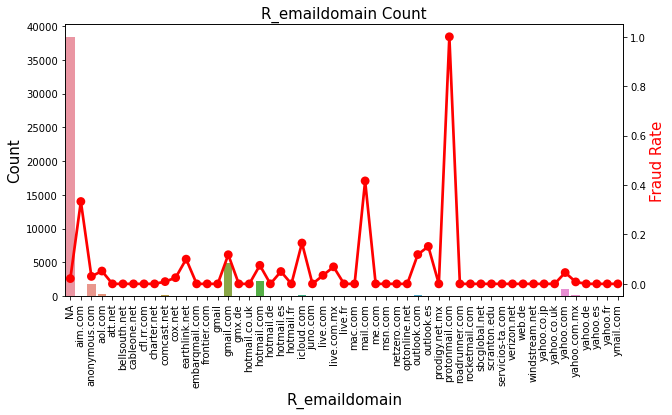

In [332]:
Plot_For_Cat_Var('R_emaildomain')

## M1-M9

In [333]:
training_data.loc[:,'M1':'M9'].apply(pd.value_counts)

M1       M2       M3       M4       M5       M6       M7       M8  \
F       3.0   2772.0   5630.0      NaN  11029.0  19243.0  17836.0  13103.0   
M0      NaN      NaN      NaN  16457.0      NaN      NaN      NaN      NaN   
M1      NaN      NaN      NaN   4352.0      NaN      NaN      NaN      NaN   
M2      NaN      NaN      NaN   4996.0      NaN      NaN      NaN      NaN   
T   26969.0  24200.0  21342.0      NaN   9020.0  16370.0   2709.0   7443.0   

         M9  
F    3203.0  
M0      NaN  
M1      NaN  
M2      NaN  
T   17343.0

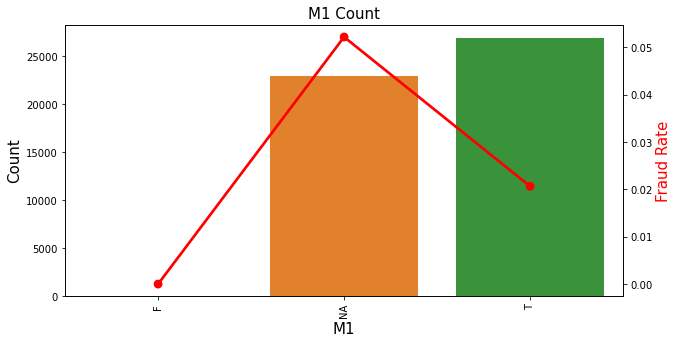

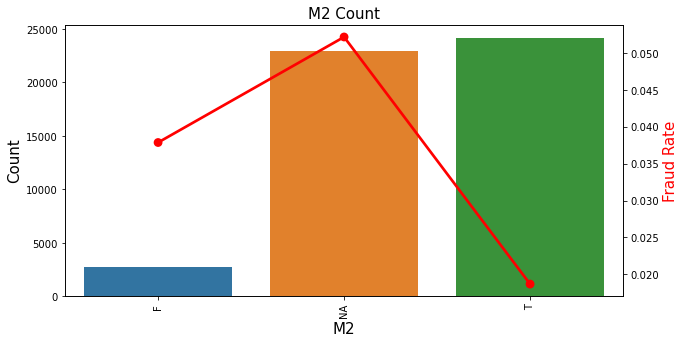

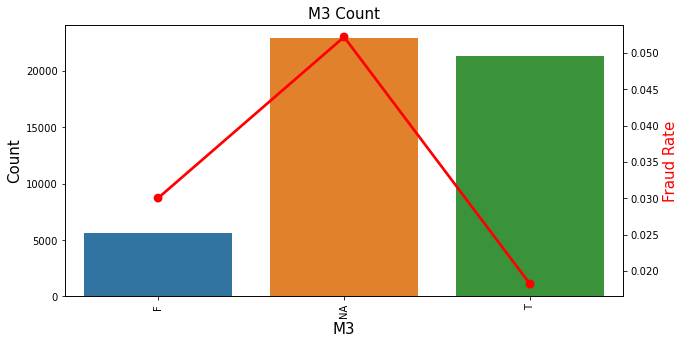

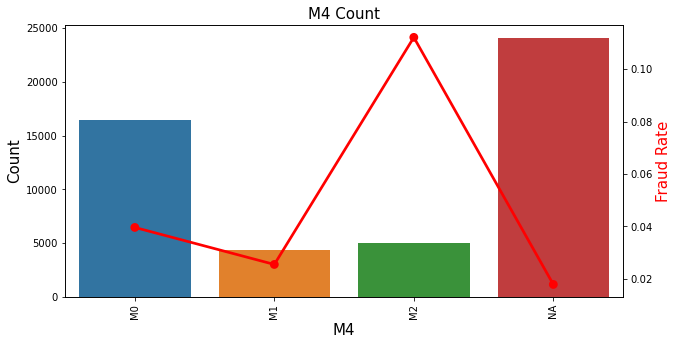

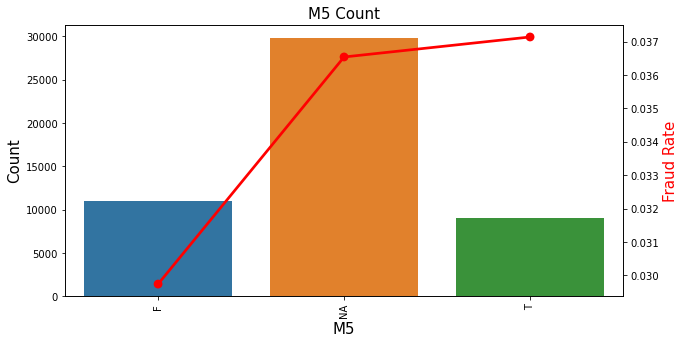

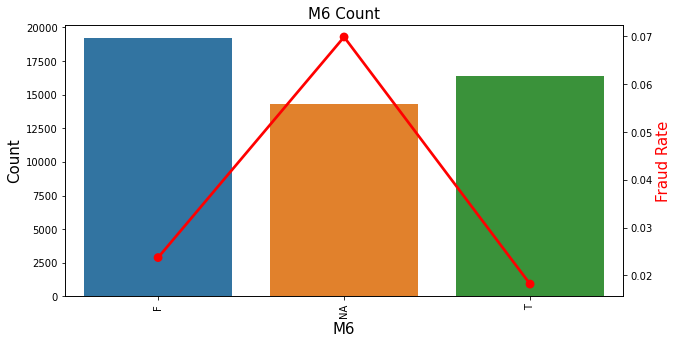

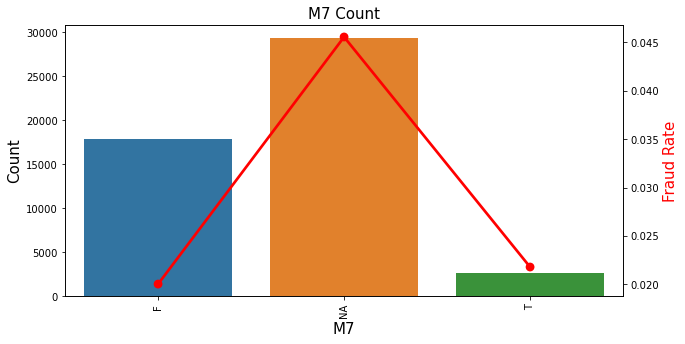

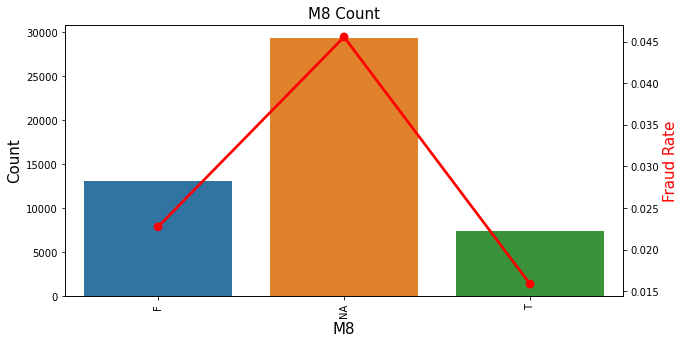

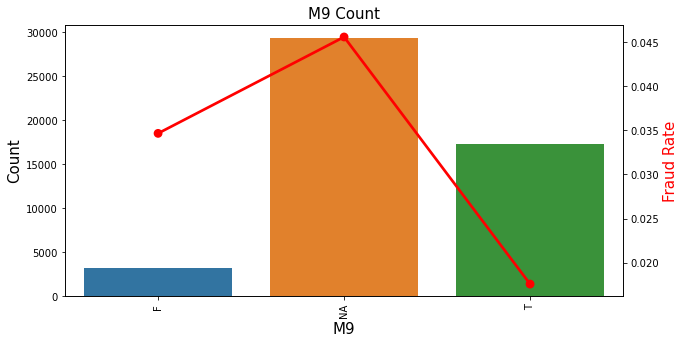

In [334]:
M_cols = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
for col in M_cols:
    Plot_For_Cat_Var(col)

In [335]:
gc.collect()

69956

## id12 - id38

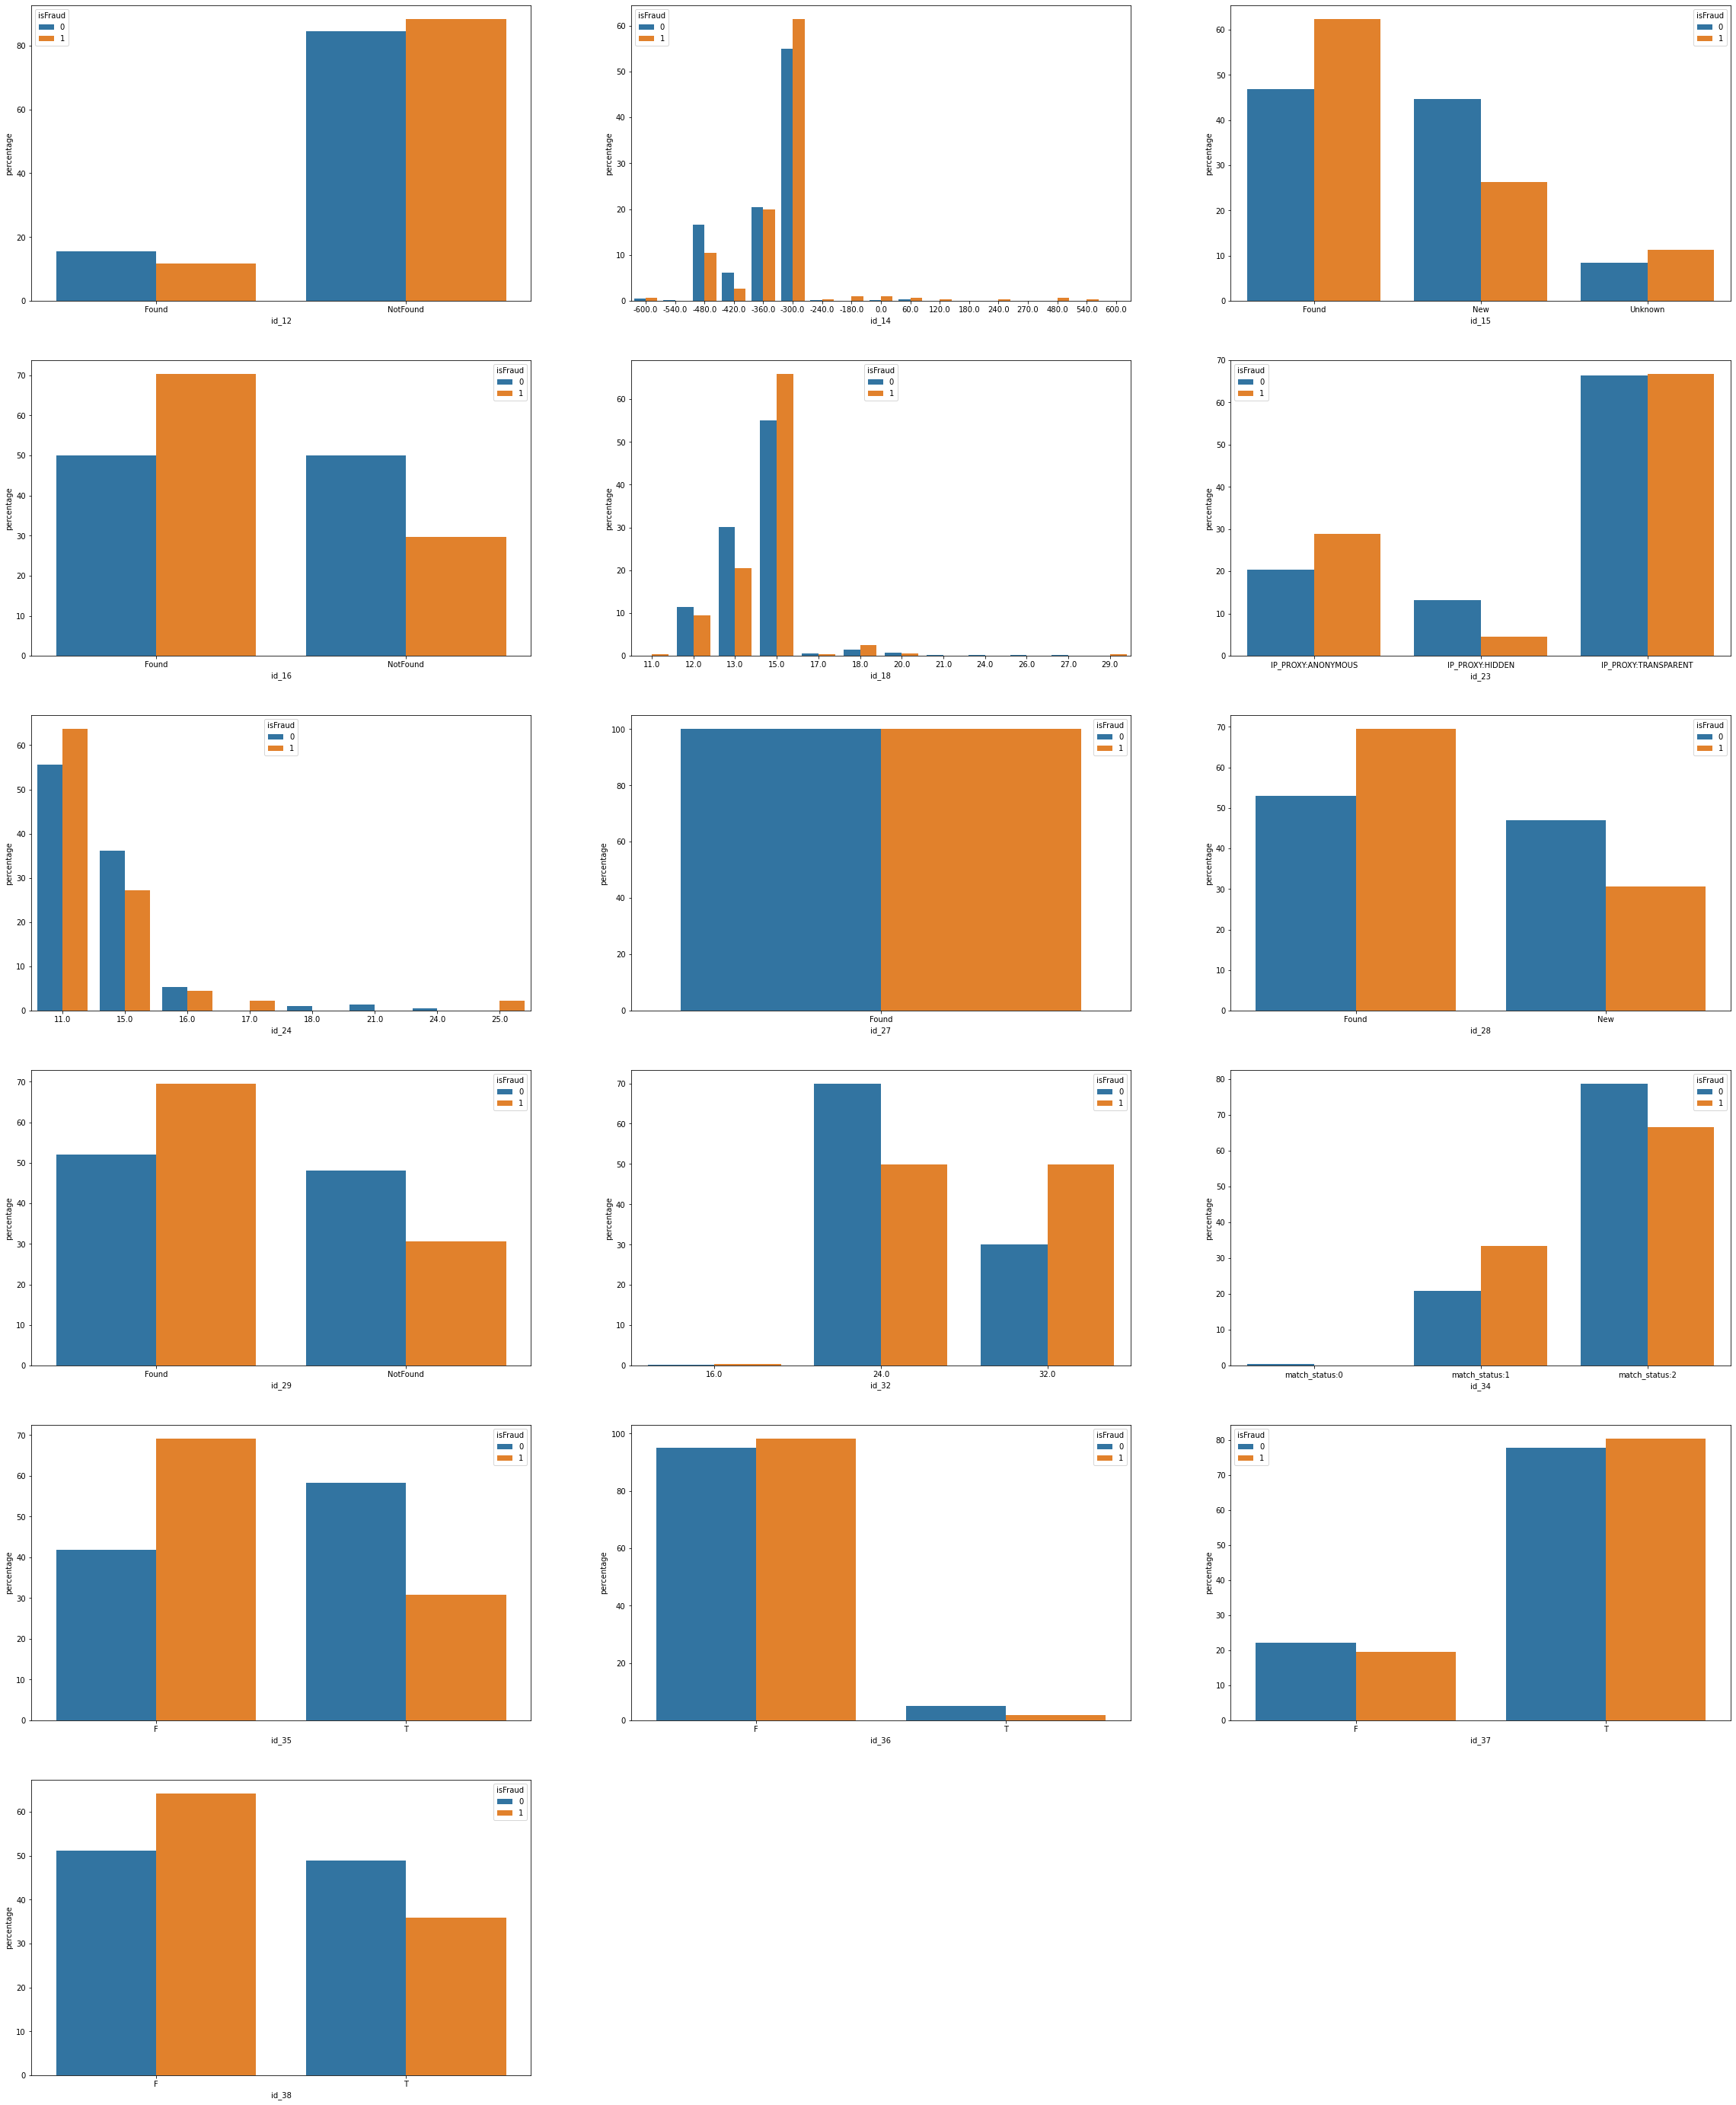

In [336]:
#Plotting graphs for all id columns to understand the distribution
plt.figure(figsize=(40,50))
var = ['training_data_id_' + str(i) for i in range(1,17)]
col = ['id_'+str(i) for i in [12,14,15,16,18,23,24,27,28,29,32,34,35,36,37,38]]
for i,j,k in zip(var,col,range(1,19)):
    i = (training_data.groupby(['isFraud'])[j]
                         .value_counts(normalize=True)
                         .rename('percentage')
                         .mul(100)
                         .reset_index()
                         .sort_values(j))
    plt.subplot(6,3,k)
    sns.barplot(x=j, y="percentage", hue="isFraud", data=i)
plt.show()

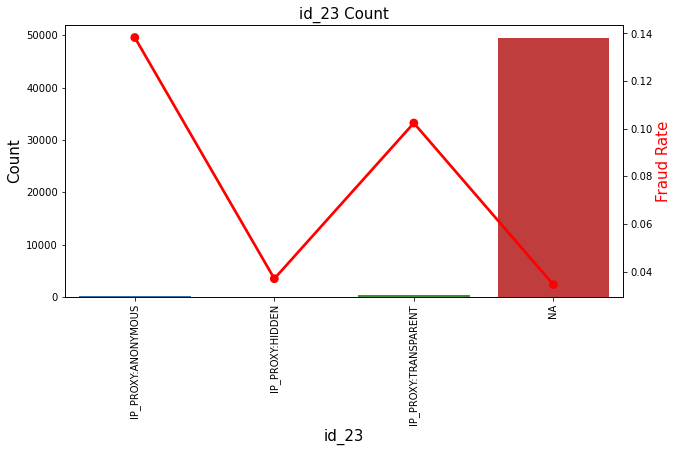

In [337]:
Plot_For_Cat_Var('id_23')

It's intriguing to learn that the anonymous IP proxy would have a higher fraud rate. If someone were to engage in fraudulent activity, it makes sense that they would wish to protect their identity.

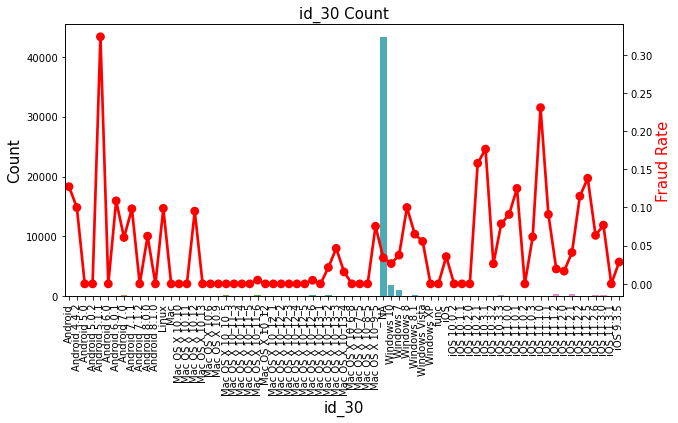

In [338]:
Plot_For_Cat_Var('id_30')

In [339]:
#Aggregating the operating systems
training_data['major_os'] = training_data["id_30"].str.split(' ', expand = True)[[0]]
#testing_data['major_os'] = testing_data["id_30"].str.split(' ', expand = True)[[0]]

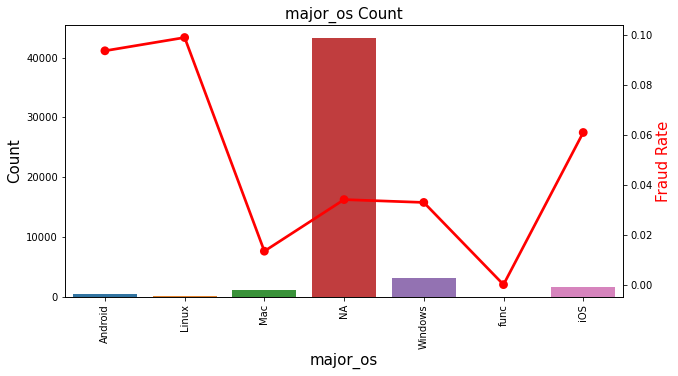

In [340]:
Plot_For_Cat_Var('major_os')

Several well-known operating systems seem to exhibit a very consistent fraud rate. For "other" operating systems, the fraud rate is noticeably higher.
It's strange that more iOS smartphones are visible than Android ones, despite the fact that Android is the most popular mobile operating system.

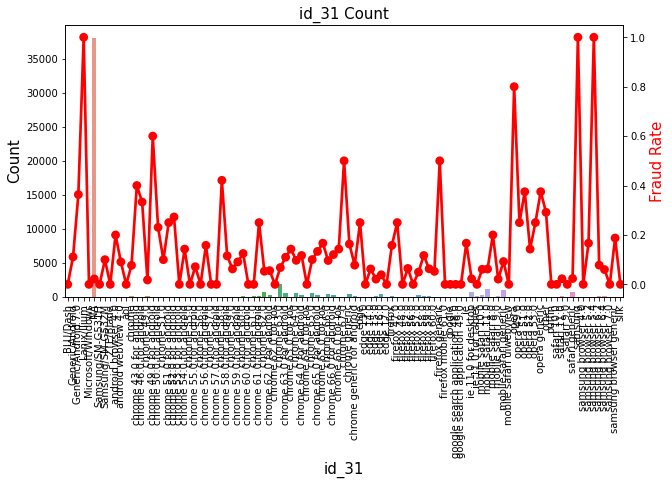

In [341]:
Plot_For_Cat_Var('id_31')

In [342]:
#reducing the no. of categories
training_data['browser'] = training_data["id_31"].str.split(' ', expand = True)[[0]]
#testing_data['browser'] =  testing_data["id_31"].str.split(' ', expand = True)[[0]]

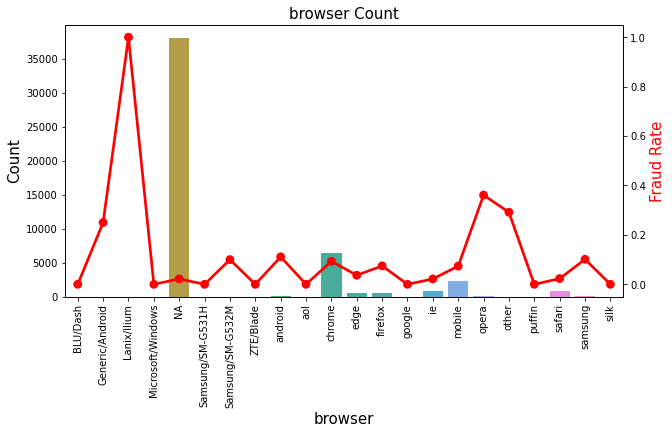

In [343]:
Plot_For_Cat_Var('browser')

In [344]:
gc.collect()

11077

In [345]:
training_data = training_data.drop('major_os', axis=1)
training_data = training_data.drop('browser', axis=1)
#testing_data = testing_data.drop('browser', axis=1)
training_data = training_data.drop('P_parent_emaildomain', axis=1)

In [346]:
gc.collect()

32

A number of our browsers have a ridiculously high fraud rate. The lack of such browsers is probably to blame for this.

## DeviceType and Decive Info

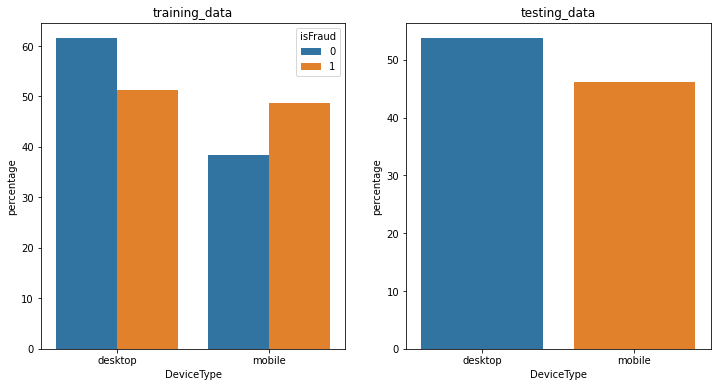

In [347]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
training_data_DeviceType = (training_data[~training_data['DeviceType'].isnull()].groupby(['isFraud'])['DeviceType'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('DeviceType'))
sns.barplot(x="DeviceType", y="percentage", hue="isFraud", data=training_data_DeviceType)
plt.title('training_data')
plt.subplot(1,2,2)
testing_data_DeviceType =testing_data[~testing_data['DeviceType'].isnull()]['DeviceType'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
sns.barplot(x="index", y="percentage", data=testing_data_DeviceType)
plt.xlabel('DeviceType')
plt.title('testing_data')
plt.show()

Both mobile and Desktop have almost same percentage of Fraud

In [348]:
print ("Unique Devices = ",training_data['DeviceInfo'].nunique())
training_data['DeviceInfo'].value_counts()[:10]

Unique Devices =  751


Windows                  4022
iOS Device               1626
MacOS                    1106
Trident/7.0               625
rv:11.0                   175
rv:57.0                    82
SM-J700M Build/MMB29K      38
SM-G610M Build/MMB29K      34
SM-G531H Build/LMY48B      33
rv:59.0                    31
Name: DeviceInfo, dtype: int64

In [349]:
#by grouping similar devices create new variables
# Reference: https://www.kaggle.com/jolly2136/eda-fe-xgb
def transform_DeviceInfo(datafrm):
    datafrm['DeviceCorp'] = datafrm['DeviceInfo']
    datafrm.loc[datafrm['DeviceInfo'].str.contains('HUAWEI|HONOR', case=False, na=False, regex=True), 'DeviceCorp'] = 'HUAWEI'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('OS', na=False, regex=False), 'DeviceCorp'] = 'APPLE'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('Idea|TA', case=False, na=False), 'DeviceCorp'] = 'Lenovo'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('Moto|XT|Edison', case=False, na=False), 'DeviceCorp'] = 'Moto'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('MI|Mi|Redmi', na=False), 'DeviceCorp'] = 'Mi'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('VS|LG|EGO', na=False), 'DeviceCorp'] = 'LG'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('ONE TOUCH|ALCATEL', case=False, na=False, regex=False), 'DeviceCorp'] = 'ALCATEL'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('ONE A', na=False, regex=False), 'DeviceCorp'] = 'ONEPLUS'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('OPR6', na=False, regex=False), 'DeviceCorp'] = 'HTC'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('Nexus|Pixel', case=False, na=False, regex=True), 'DeviceCorp'] = 'google'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('STV', na=False, regex=False), 'DeviceCorp'] = 'blackberry'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('ASUS', case=False, na=False, regex=False), 'DeviceCorp'] = 'ASUS'
    datafrm.loc[datafrm['DeviceInfo'].str.contains('BLADE', case=False, na=False, regex=False), 'DeviceCorp'] = 'ZTE'
    
    datafrm['DeviceCorp'] = datafrm['DeviceInfo'].astype('str').str.split(':', expand=True)[0].                                str.split('-', expand=True)[0].str.split(expand=True)[0]
    
    datafrm.loc[datafrm['DeviceInfo'].isin(['rv', 'SM', 'GT', 'SGH']), 'DeviceCorp'] = 'SAMSUNG'
    datafrm.loc[datafrm['DeviceInfo'].str.startswith('Z', na=False), 'DeviceCorp'] = 'ZTE'
    datafrm.loc[datafrm['DeviceInfo'].str.startswith('KF', na=False), 'DeviceCorp'] = 'Amazon'
    
    for i in ['D', 'E', 'F', 'G']:
        datafrm.loc[datafrm['DeviceInfo'].str.startswith(i, na=False), 'DeviceCorp'] = 'SONY'
    datafrm.loc[datafrm['DeviceCorp'].isin(datafrm['DeviceCorp'].value_counts()                                 [datafrm['DeviceCorp'].value_counts() < 100].index), 'DeviceCorp'] = 'Other'
    datafrm['DeviceCorp'] = datafrm['DeviceCorp'].str.upper()
    
    return datafrm

In [350]:
training_data = transform_DeviceInfo(training_data)
testing_data = transform_DeviceInfo(testing_data)

In [351]:
#Change NAN into np.nan
def settingNaN(value):
    if value=='NAN':
        return np.nan
    else:
        return value

In [352]:
training_data['DeviceCorp'] = training_data['DeviceCorp'].apply(settingNaN)
testing_data['DeviceCorp'] = testing_data['DeviceCorp'].apply(settingNaN)

In [353]:
training_data.DeviceCorp.head(3)

65032     NaN
484332    NaN
72332     NaN
Name: DeviceCorp, dtype: object

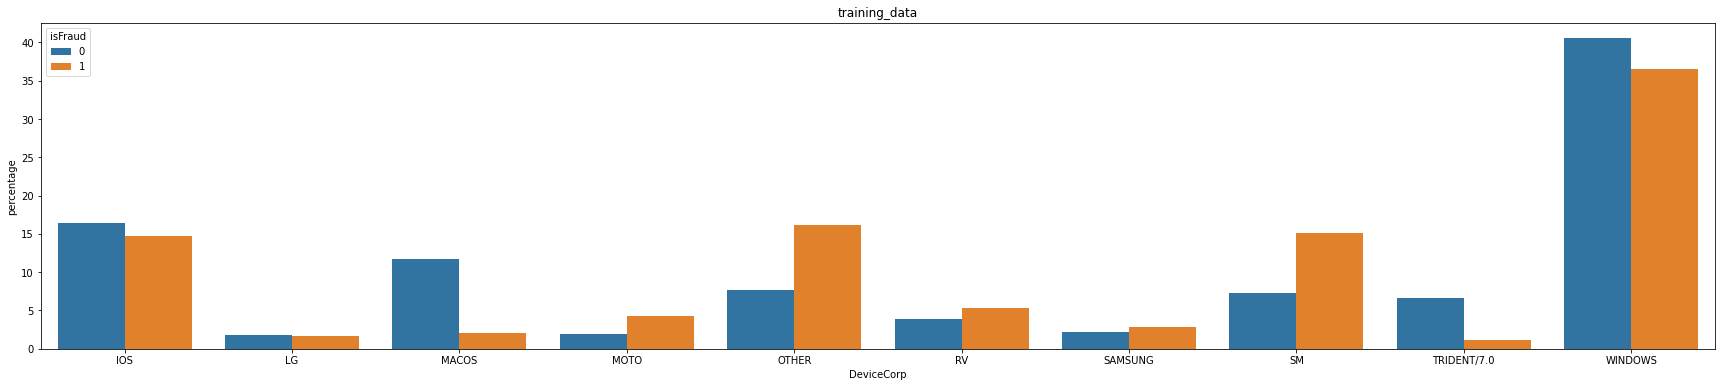

In [354]:
plt.figure(figsize=(30,6))
training_data_DeviceCorp = (training_data[~training_data['DeviceCorp'].isnull()].groupby(['isFraud'])['DeviceCorp'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().sort_values('DeviceCorp'))
sns.barplot(x="DeviceCorp", y="percentage", hue="isFraud", data=training_data_DeviceCorp)
plt.title('training_data')
plt.show()

Samsung, Moto and LG have higher fraud 

In [355]:
gc.collect()

6459

In [356]:
training_data_bkp1 =training_data.copy()

In [357]:
testing_data_bkp1 = testing_data.copy()

# Modelling

In [358]:
training_data.head(3)

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
65032         3052032        0        1463529       117.00000         W   
484332        3471332        0       12602815       135.00000         W   
72332         3059332        0        1618793        50.84375         C   

        card1  card2  card3 card4  card5  card6  addr1  addr2  dist1  dist2  \
65032    9500  321.0  150.0  visa  226.0  debit  204.0   87.0    NaN    NaN   
484332   7307  555.0  150.0  visa  226.0  debit  170.0   87.0   14.0    NaN   
72332    4564  555.0  117.0  visa  226.0  debit    NaN    NaN    NaN    NaN   

        P_emaildomain R_emaildomain    C1    C2   C3   C4    C5    C6   C7  \
65032             NaN            NA   3.0   5.0  0.0  0.0   0.0   1.0  0.0   
484332  anonymous.com            NA  36.0  30.0  0.0  0.0  26.0  24.0  0.0   
72332       gmail.com     gmail.com   1.0   1.0  0.0  1.0   0.0   1.0  1.0   

         C8    C9  C10   C11  C12    C13   C14     D1     D2    D3     D4  \
65032   0.0   3.0  0.0   2.0  0.0   14.0   3.0  490.0  490.0  45.0    NaN   
484332  0.0  23.0  0.0  26.0  0.0  197.0  32.0  320.0  320.0   4.0  321.0   
72332   1.0   0.0  1.0   1.0  1.0    1.0   1.0    0.0    NaN   NaN    0.0   

          D5   D6  D7  D8  D9    D10    D11  D12  D13  D14    D15  M1  M2  M3  \
65032    NaN  NaN NaN NaN NaN  130.0    NaN  NaN  NaN  NaN  490.0  NA  NA  NA   
484332  55.0  NaN NaN NaN NaN  321.0  321.0  NaN  NaN  NaN  321.0   T   T   T   
72332    NaN  0.0 NaN NaN NaN    0.0    NaN  0.0  0.0  0.0    0.0  NA  NA  NA   

        M4  M5  M6  M7  M8  M9   V1   V2   V3   V4   V5   V6   V7   V8   V9  \
65032   M1   T   T  NA  NA  NA  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
484332  NA  NA   F   F   F   T  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
72332   M2  NA  NA  NA  NA  NA  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

        V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  \
65032   NaN  NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
484332  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
72332   NaN  NaN  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

        V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  \
65032   1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN  NaN  NaN   
484332  1.0  1.0  1.0  0.0  0.0  2.0  2.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
72332   1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0   

        V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  \
65032   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
484332  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  2.0  2.0  0.0  0.0   
72332   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0   

        V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  \
65032   NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
484332  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
72332   1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

        V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  \
65032   1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
484332  1.0  1.0  0.0  2.0  2.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   
72332   1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   

        V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  \
65032   0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
484332  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  2.0  2.0  0.0  0.0   
72332   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0   

        V94  V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  V105  \
65032   0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
484332  0.0  0.0  2.0  0.0  0.0  2.0   0.0   0.0

In [359]:
testing_data.head(3)

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
446737        4110286       33062367            75.0         S   2616  327.0   
161103        3824652       23984059            59.0         W   6439  512.0   
467747        4131296       33421162           108.5         W   7664  490.0   

        card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
446737  150.0    discover  223.0  credit  476.0   87.0    NaN  446.0   
161103  150.0  mastercard  224.0   debit  384.0   87.0    NaN    NaN   
467747  150.0        visa  226.0   debit  264.0   87.0    NaN    NaN   

        P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8  \
446737            NaN           NaN  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
161103  anonymous.com           NaN  1.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0   
467747      yahoo.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   

         C9  C10  C11  C12  C13  C14     D1     D2     D3     D4     D5  D6  \
446737  0.0  1.0  1.0  0.0  1.0  1.0    0.0    NaN    NaN    NaN    NaN NaN   
161103  1.0  0.0  1.0  0.0  2.0  1.0  104.0  104.0  105.0  105.0  105.0 NaN   
467747  1.0  0.0  1.0  0.0  2.0  1.0    0.0    0.0    0.0    0.0    0.0 NaN   

        D7     D8     D9     D10    D11  D12    D13  D14     D15   M1   M2  \
446737 NaN  770.5  0.625  1063.0    NaN  NaN  738.0  0.0  1063.0  NaN  NaN   
161103 NaN    NaN    NaN     0.0  338.0  NaN    NaN  NaN   105.0    T    F   
467747 NaN    NaN    NaN     0.0    0.0  NaN    NaN  NaN     0.0    T    T   

         M3   M4   M5   M6   M7   M8   M9   V1   V2   V3   V4   V5   V6   V7  \
446737  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
161103    F   M0    F    F    F    F    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
467747    T   M0    T    T    F    F    F  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

         V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  \
446737  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
161103  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
467747  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   

        V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  \
446737  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  NaN   
161103  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
467747  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

        V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  \
446737  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
161103  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
467747  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   

        V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
446737  NaN  NaN  NaN  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0   
161103  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   
467747  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   

        V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  \
446737  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
161103  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
467747  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   

        V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  \
446737  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0   
161103  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
467747  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   

        V92  V93  V94  V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  \
446737  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   
161103  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [360]:
gc.collect()

0

## Impute Missing

In [361]:
def fillna(datafrm):
    datafrm.fillna(-999, inplace = True)
    
fillna(training_data)
fillna(testing_data)

In [362]:
def clean_inf_nan(datafrm):
    return datafrm.replace([np.inf, -np.inf], np.nan)   

Cleaning infinite values to NaN

In [363]:
training_data = clean_inf_nan(training_data)
testing_data = clean_inf_nan(testing_data)

## Label Encoding

In [364]:
cat_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 
            'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'Hour_Alert', 'new_card3','card3Values', 'DeviceCorp',
            'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
            'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
            'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
for col in cat_cols:
    if col in training_data.columns:
        le = LabelEncoder()
        le.fit(list(training_data[col].astype(str).values) + list(testing_data[col].astype(str).values))
        training_data[col] = le.transform(list(training_data[col].astype(str).values))
        testing_data[col] = le.transform(list(testing_data[col].astype(str).values))

In [365]:
cat_cols_testing_data = testing_data.columns

In [366]:
training_data.dtypes.head()

TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float16
ProductCD           int64
dtype: object

In [367]:
gc.collect()

0

In [368]:
training_data.shape

(49906, 440)

In [369]:
testing_data.shape

(50000, 439)

In [370]:
testing_data.head(3)

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
446737        4110286       33062367            75.0          3   2616  327.0   
161103        3824652       23984059            59.0          4   6439  512.0   
467747        4131296       33421162           108.5          4   7664  490.0   

        card3  card4  card5  card6  addr1  addr2  dist1  dist2  P_emaildomain  \
446737  150.0      2  223.0      1  476.0   87.0 -999.0  446.0              0   
161103  150.0      3  224.0      2  384.0   87.0 -999.0 -999.0              2   
467747  150.0      4  226.0      2  264.0   87.0 -999.0 -999.0             54   

        R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  \
446737              0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0   
161103              0  1.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   
467747              0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0   

        C12  C13  C14     D1     D2     D3     D4     D5     D6     D7     D8  \
446737  0.0  1.0  1.0    0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  770.5   
161103  0.0  2.0  1.0  104.0  104.0  105.0  105.0  105.0 -999.0 -999.0 -999.0   
467747  0.0  2.0  1.0    0.0    0.0    0.0    0.0    0.0 -999.0 -999.0 -999.0   

             D9     D10    D11    D12    D13    D14     D15  M1  M2  M3  M4  \
446737    0.625  1063.0 -999.0 -999.0  738.0    0.0  1063.0   0   0   0   0   
161103 -999.000     0.0  338.0 -999.0 -999.0 -999.0   105.0   3   1   1   1   
467747 -999.000     0.0    0.0 -999.0 -999.0 -999.0     0.0   3   3   3   1   

        M5  M6  M7  M8  M9     V1     V2     V3     V4     V5     V6     V7  \
446737   0   0   0   0   0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
161103   1   1   1   1   1    1.0    1.0    1.0    1.0    1.0    1.0    1.0   
467747   3   3   1   1   1    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

           V8     V9    V10    V11  V12  V13  V14  V15  V16  V17  V18  V19  \
446737 -999.0 -999.0 -999.0 -999.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0   
161103    1.0    1.0    0.0    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   
467747    1.0    1.0    0.0    0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0   

        V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
446737  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   
161103  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
467747  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

        V34    V35    V36    V37    V38    V39    V40    V41    V42    V43  \
446737  0.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0   
161103  0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0   
467747  0.0    1.0    1.0    1.0    1.0    0.0    0.0    1.0    0.0    0.0   

          V44    V45    V46    V47    V48    V49    V50    V51    V52  V53  \
446737 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0 -999.0  0.0   
161103    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0  1.0   
467747    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0  1.0   

        V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  \
446737  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
161103  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
467747  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   

        V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  \
446737  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0   
161103  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
467747  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   

        V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  V95  \
446737  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
161103  1.0  1.0

In [371]:
training_data_bkp = training_data.copy()

In [372]:
testing_data_bkp = testing_data.copy()

In [373]:
training_data_bkp.to_csv(File_Path + 'training_data_for_modeling.csv', index=False)
testing_data_bkp.to_csv(File_Path + 'testing_data_for_modeling.csv', index=False)

## Feature Engineering

In [374]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.
    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) /              np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Create several lists to handle variables

In [375]:
id_var = ['TransactionID']
target_var = ['isFraud']
predictors = [v for v in training_data.columns if v not in id_var + target_var]

Calculate Fisher Score for all variable

In [376]:
fs = FisherScore(training_data, target_var[0], predictors)
fs_datafrm = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_datafrm = fs_datafrm.sort_values('fisherscore', ascending=False)
fs_datafrm.head(100)

predictor  fisherscore
435  LogTransactionAmt          inf
23                  C9          inf
2            ProductCD     0.511038
408              id_17     0.496811
403              id_12     0.454230
430         DeviceType     0.449607
411              id_20     0.445894
428              id_37     0.444709
427              id_36     0.429890
404              id_13     0.416915
429              id_38     0.369478
14       R_emaildomain     0.362158
8                card6     0.360721
406              id_15     0.356550
419              id_28     0.356108
420              id_29     0.352535
393              id_02     0.342629
44                  M1     0.338780
426              id_35     0.321626
422              id_31     0.321397
410              id_19     0.317108
45                  M2     0.301061
407              id_16     0.300504
315               V263     0.297226
431         DeviceInfo     0.283957
317               V265     0.281825
437         DeviceCorp     0.252191
52                  M9     0.239417
316               V264     0.233159
46                  M3     0.227807
409              id_18     0.225902
50                  M7     0.189380
47                  M4     0.169317
434         Hour_Alert     0.121382
254               V202     0.101293
417              id_26     0.099186
263               V211     0.098512
416              id_25     0.096378
212               V160     0.096081
418              id_27     0.095736
414              id_23     0.086741
423              id_32     0.081883
265               V213     0.077983
256               V204     0.076591
415              id_24     0.075400
412              id_21     0.072732
217               V165     0.071333
413              id_22     0.069819
3                card1     0.069776
13       P_emaildomain     0.068784
433               hour     0.065856
424              id_33     0.058933
405              id_14     0.057224
264               V212     0.055749
255               V203     0.055727
48                  M5     0.051963
425              id_34     0.051099
17                  C3     0.047333
436        card3Values     0.038204
0        TransactionDT     0.033869
216               V164     0.032849
49                  M6     0.032071
384               V332     0.031595
385               V333     0.029558
184               V132     0.025229
383               V331     0.023954
178               V126     0.023684
359               V307     0.023587
369               V317     0.021908
186               V134     0.021235
368               V316     0.018397
6                card4     0.018187
185               V133     0.017890
218               V166     0.016824
358               V306     0.015571
179               V127     0.015525
51                  M8     0.014071
360               V308     0.014007
180               V128     0.013505
432                day     0.012408
188               V136     0.010789
421              id_30     0.010429
189               V137     0.010175
187               V135     0.008842
371               V319     0.008184
373               V321     0.007063
370               V318     0.004739
372               V320     0.004216
150                V98     0.000000
163               V111     0.000000
161               V109     0.000000
160               V108     0.000000
159               V107     0.000000
158               V106     0.000000
157               V105     0.000000
156               V104     0.000000
155               V103     0.000000
154               V102     0.000000
153               V101     0.000000
21                  C7     0.000000

Visualize the Fisher Score

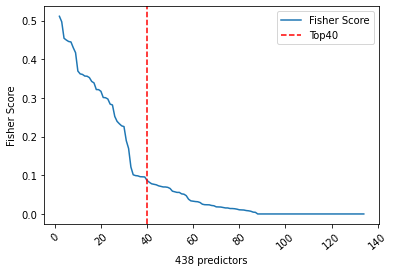

In [377]:
plt.plot(fs_datafrm['fisherscore'].values.squeeze())
plt.axvline(x=40, linestyle='dashed', color='red')
plt.xticks(rotation=40)
plt.xlabel(str(fs_datafrm.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top40'])
plt.show()

In [378]:
#Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_datafrm['predictor'][:i]
    clf = GradientBoostingClassifier(n_estimators=100)
    fs_scores.append(cross_validate(clf, training_data_bkp[top_n_predictors], training_data_bkp[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

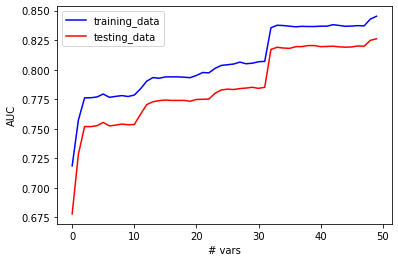

In [379]:
#How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['training_data', 'testing_data'])
plt.show()

In [380]:
#Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_datafrm['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50


array(['LogTransactionAmt', 'C9', 'ProductCD', 'id_17', 'id_12',
       'DeviceType', 'id_20', 'id_37', 'id_36', 'id_13', 'id_38',
       'R_emaildomain', 'card6', 'id_15', 'id_28', 'id_29', 'id_02', 'M1',
       'id_35', 'id_31', 'id_19', 'M2', 'id_16', 'V263', 'DeviceInfo',
       'V265', 'DeviceCorp', 'M9', 'V264', 'M3', 'id_18', 'M7', 'M4',
       'Hour_Alert', 'V202', 'id_26', 'V211', 'id_25', 'V160', 'id_27',
       'id_23', 'id_32', 'V213', 'V204', 'id_24', 'id_21', 'V165',
       'id_22', 'card1', 'P_emaildomain'], dtype=object)

In [381]:
testing_data['isFraud'] = 'testing_data'
datafrm = pd.concat([training_data, testing_data], axis=0, sort=False)
datafrm = datafrm.reset_index()
datafrm = datafrm.drop('index', axis=1)

In [384]:
training_data, testing_data = datafrm[datafrm['isFraud'] != 'testing_data'],datafrm[datafrm['isFraud'] == 'testing_data'].drop('isFraud', axis=1)

### Set X and Y

In [385]:
X = training_data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y = training_data.sort_values('TransactionDT')['isFraud'].astype(bool)
testing_data = testing_data.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'], axis=1)

In [386]:
# target   = y<br>
# #features = X<br>
# features = X.columns[X.columns!=target]

In [387]:
print('training_data shape: %d, %d' %(training_data.shape[0],training_data.shape[1]))
print('testing_data shape: %d, %d' %(testing_data.shape[0],testing_data.shape[1]))
print('X shape: %d, %d' %(X.shape[0],X.shape[1]))
print('y shape: %d, 1' %(y.shape[0]))

training_data shape: 49906, 440
testing_data shape: 50000, 437
X shape: 49906, 437
y shape: 49906, 1


In [388]:
gc.collect()

7288

## training_data testing_data Split

In [389]:
X_training_data, X_testing_data, y_training_data, y_testing_data = train_test_split(X, y, test_size=0.30, random_state=45, stratify=y)

In [390]:
X_training_data.shape

(34934, 437)

In [391]:
X_testing_data.shape

(14972, 437)

In [392]:
substring = 'Found'
X_training_data[X_training_data.apply(lambda row: row.astype(str).str.contains(substring, case=False).any(), axis=1)]

Empty DataFrame
Columns: [TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, P_emaildomain, R_emaildomain, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, ...]
Index: []

In [393]:
#del training_data, X, y

## First Experimental Setup of models

In [394]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 100) #500
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier(n_estimators=100) #100
svm          = SVC(gamma = "scale", probability = True)
#SDG          = SGDClassifier()
#neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()
adaBoost     = AdaBoostClassifier()
#bagging      = BaggingClassifier()
#histGB       = HistGradientBoostingClassifier()

In [395]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
#          "SDG"          :SDG
#          "svm"          :svm,
#          "neighbors"    :neighbors,
#          "adaBoost"     :adaBoost,
         }

In [396]:
for model in models:
    models[model].fit(X_training_data,y_training_data)
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully


### Compute Accuracy and AUC for each model on training_data data

In [397]:
performances = {}

In [398]:
for model in models:
    predictions   = models[model].predict(X_training_data)
    probabilities = DataFrame(models[model].predict_proba(X_training_data))[1]
    accuracy      = accuracy_score(y_training_data,predictions)
    auc           = roc_auc_score(array(y_training_data),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [399]:
DataFrame(performances)

tree  logistic  randomForest  boostedTree
Accuracy   1.0  0.965592           1.0     0.975382
AUC        1.0  0.746767           1.0     0.892904

### Compute Accuracy and AUC for each model on tset data

In [400]:
performances = {}

In [401]:
for model in models:
    predictions   = models[model].predict(X_testing_data)
    probabilities = DataFrame(models[model].predict_proba(X_testing_data))[1]
    accuracy      = accuracy_score(y_testing_data,predictions)
    auc           = roc_auc_score(array(y_testing_data),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [402]:
# for model in models:
#     predictions   = models[model].predict(testing_data)
#     probabilities = DataFrame(models[model].predict_proba(testing_data))[1]
#     accuracy      = accuracy_score(y_testing_data,predictions)
#     auc           = roc_auc_score(array(y_testing_data),array(probabilities))
    
#     performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [403]:
DataFrame(performances)

tree  logistic  randomForest  boostedTree
Accuracy  0.947903  0.965269      0.974619     0.972883
AUC       0.666157  0.737176      0.878519     0.866095

In [404]:
DataFrame(performances)

tree  logistic  randomForest  boostedTree
Accuracy  0.947903  0.965269      0.974619     0.972883
AUC       0.666157  0.737176      0.878519     0.866095

## Second experimental Setup

## Logistic Regression

In [653]:
from sklearn.linear_model import SGDClassifier

In [654]:
#applying logistic regression
sc = StandardScaler()
x_training_data_sc = sc.fit_transform(X_training_data)
x_testing_data_sc = sc.transform(X_testing_data)

In [655]:
#with Initial default value
clf = SGDClassifier(loss="log")
clf.fit(x_training_data_sc,y_training_data)
y_training_datapred=clf.predict_proba(x_training_data_sc)
y_testing_datapred = clf.predict_proba(x_testing_data_sc)

In [656]:
print('training_data auc with default parameter:',roc_auc_score(y_training_data,y_training_datapred[:,1]))
print('testing_data auc with default parameter:',roc_auc_score(y_testing_data,y_testing_datapred[:,1]))

training_data auc with default parameter: 0.7910087528641697
testing_data auc with default parameter: 0.7546574382723993


## Lasso and Ridge Regularization (Hyper Parameter Tuning)

In [657]:
for i in [10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]:
    for j in ['l1','l2']:
        print('For alpha:',i,'for reg:',j)
        clf = SGDClassifier(loss="log",class_weight='balanced',alpha=i,penalty=j)
        clf.fit(x_training_data_sc,y_training_data)
        y_training_datapred=clf.predict_proba(x_training_data_sc)
        y_cvpred = clf.predict_proba(x_testing_data_sc)
        print('training_data auc:',roc_auc_score(y_training_data,y_training_datapred[:,1]))
        print('testing_data auc:',roc_auc_score(y_testing_data,y_cvpred[:,1]))
        print('-'*30)

For alpha: 0.0001 for reg: l1
training_data auc: 0.7793953897009673
testing_data auc: 0.7477639123111725
------------------------------
For alpha: 0.0001 for reg: l2
training_data auc: 0.8142271233496006
testing_data auc: 0.7894860746902264
------------------------------
For alpha: 0.001 for reg: l1
training_data auc: 0.7767673569653903
testing_data auc: 0.7377384455563427
------------------------------
For alpha: 0.001 for reg: l2
training_data auc: 0.7467870342463903
testing_data auc: 0.7247457526085173
------------------------------
For alpha: 0.01 for reg: l1
training_data auc: 0.7635286619835318
testing_data auc: 0.7613273620296935
------------------------------
For alpha: 0.01 for reg: l2
training_data auc: 0.8279856192595856
testing_data auc: 0.8202653185235059
------------------------------
For alpha: 0.1 for reg: l1
training_data auc: 0.6170770688675855
testing_data auc: 0.6299533205780727
------------------------------
For alpha: 0.1 for reg: l2
training_data auc: 0.816777441

### Confusion Matrix 

In [658]:
from sklearn.metrics import confusion_matrix

In [659]:
# clf = SGDClassifier(loss="log",class_weight='balanced',alpha=0.1,penalty='l2')<br>
# clf.fit(x_training_data_sc,y_training_data)<br>
# y_training_datapred=clf.predict(x_training_data_sc)<br>
# y_testing_datapred = clf.predict(x_testing_data_sc)

In [660]:
# cm_training_data = confusion_matrix(y_training_data,y_training_datapred)<br>
# cm_testing_data  =confusion_matrix(y_testing_data,y_testing_datapred)

In [661]:
# plt.figure(figsize=(12,5))<br>
# plt.subplot(1,2,1)<br>
# sns.heatmap(cm_training_data,annot=True,fmt='.2f')<br>
# plt.title('training_data')<br>
# plt.subplot(1,2,2)<br>
# sns.heatmap(cm_testing_data,annot=True,fmt='.2f')<br>
# plt.title('testing_data')

## Boosting Tree 

In [662]:
#Initail model with default value
boosting_tree = GradientBoostingClassifier()
boosting_tree.fit(X_training_data,y_training_data)

GradientBoostingClassifier()

In [663]:
print('Parameters currently in use:\n')
print(boosting_tree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [664]:
boosting_tree_training_data_predict = boosting_tree.predict_proba(X_training_data)
boosting_tree_testing_data_predict = boosting_tree.predict_proba(X_testing_data)
print('base boosting tree training_data auc:', roc_auc_score(y_training_data, boosting_tree_training_data_predict[:,1]))
print('base boosting tree testing_data auc:', roc_auc_score(y_testing_data, boosting_tree_testing_data_predict[:,1]))

base boosting tree training_data auc: 0.8831357394291367
base boosting tree testing_data auc: 0.8732382299633781


## Resampling on BoostingTree(3 fold stratified cross validation)

In [665]:
#Creating function to check the quality of a split
criterion = ['squared_error', 'entropy','friedman_mse']
# Randomly take a set of features at random and splits them as the strategy used to determine the split at each node.
# Max levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Min samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Min samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# variables to consider when looking for the best split
max_features = ['auto', 'log2', None]
# Max leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
# param used for Minimal-Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Creating the random grid
random_grid_search = {'criterion': criterion,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

In order to find the optimum hyperparameters, using random grid.
Making the base model first, then adjust it
Using a 3 fold stratified cross validation and a random search of parameters with auc roc score,

In [666]:
skf = StratifiedKFold(n_splits=3)
#use all available cores while conducting a search across 60 different combinations.
Boostingtree_rndm = RandomizedSearchCV(estimator = boosting_tree, param_distributions = random_grid_search, n_iter = 60, cv = skf, scoring = 'roc_auc', verbose=0,  n_jobs = -1)
# the random search model's fit
Boostingtree_rndm.fit(X_training_data, y_training_data)

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_featu

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(), n_iter=60, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02, 0.025, 0.03, 0.035,
                                                      0.04, 0.045, 0.05],
                                        'criterion': ['squared_error',
                                                      'entropy',
                                                      'friedman_mse'],
                                        'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210,
                                                      None],
                                        'max_features': ['auto', 'log2', None],
                                        'max_leaf_nodes': [10, 30, 50, 70, 90,
                                                           110, 130, 150, 170,
                                                           190, 210],
                                        'min_impurity_decrease': [0, 5e-05,
                                                                  0.0001,
                                                                  0.0002,
                                                                  0.0005, 0.001,
                                                                  0.0015, 0.002,
                                                                  0.005, 0.01,
                                                                  0.02],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 15, 30,
                                                              50, 100]},
                   scoring='roc_auc')

In [667]:
print('Tuned best random Hyperparameters:\n')
print(Boostingtree_rndm.best_estimator_.get_params())

Tuned best random Hyperparameters:

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 150, 'max_features': 'log2', 'max_leaf_nodes': 170, 'min_impurity_decrease': 5e-05, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [668]:
best_random_boostingtree_training_data_predict = Boostingtree_rndm.predict_proba(X_training_data)
best_random_boostingtree_testing_data_predict = Boostingtree_rndm.predict_proba(X_testing_data)
print('best random boosting tree training_data auc:', roc_auc_score(y_training_data, best_random_boostingtree_training_data_predict[:,1]))
print('best random boosting tree testing_data auc:', roc_auc_score(y_testing_data, best_random_boostingtree_testing_data_predict[:,1]))

best random boosting tree training_data auc: 0.850409303383681
best random boosting tree testing_data auc: 0.8555773978743215


<br>
With Grid Search boosted Tree is overfitting and also model is taking hours to run.<br>


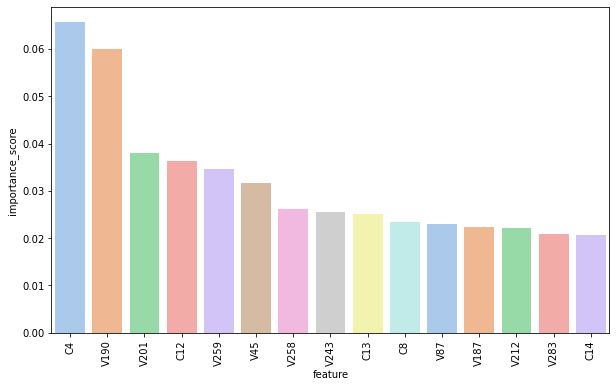

In [669]:
#Visualize variables with importantce score greater than zero
best_random_Boostingtree = Boostingtree_rndm.best_estimator_
plt.figure(figsize=(10,6))
sorted_importance_tree = sorted(zip(X_training_data.columns, best_random_Boostingtree.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_useful_tree = [ i for i in sorted_importance_tree if i[1] > 0]
a, b = zip(*sorted_importance_useful_tree)
fp = pd.DataFrame({'feature':a, 'importance_score':b})[:15]
sns.barplot(x="feature", y="importance_score", data=fp, palette = 'pastel')
plt.xticks(rotation=90)
plt.show()

Confusion matrix, without normalization
[[14430    22]
 [  400   127]]
Normalized confusion matrix
[[0.99847772 0.00152228]
 [0.75901328 0.24098672]]


<Figure size 720x432 with 0 Axes>

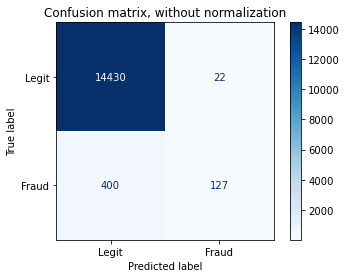

<Figure size 720x432 with 0 Axes>

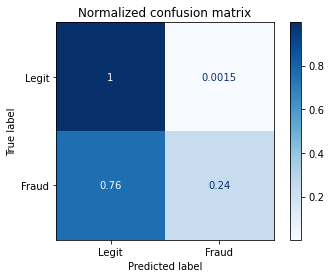

In [670]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    plt.figure(figsize=(10, 6))
    disp = plot_confusion_matrix(best_random_Boostingtree, X_testing_data, y_testing_data,
                                 display_labels=['Legit','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)
    print(disp.confusion_matrix)

In [671]:
plt.show()

This is not a good prediction for "true Frauds" plus running time of model is taking very long

### More Feature Engineering

As models are running for hours especially Grid search i am checking for the possibility of further feature reduction. Main focus is on V features, hence applying PCA on v features to check their importance.if theiry dont have any significant impact on model i can remove these features

### PCA on V Features

In [672]:
#Compressing V features through PCA

In [673]:
testing_data['isFraud'] = 'testing_data'
datafrm = pd.concat([training_data, testing_data], axis=0, sort=False)
datafrm = datafrm.reset_index()
datafrm = datafrm.drop('index', axis=1)

In [674]:
mas_v = training_data.columns[55:393]

In [675]:
for col in mas_v:
    datafrm[col] = datafrm[col].fillna((datafrm[col].min() - 2))
    datafrm[col] = (minmax_scale(datafrm[col], feature_range=(0,1)))

In [676]:
pca = PCA(n_components=338, random_state=4)
pca.fit(datafrm[mas_v])

PCA(n_components=338, random_state=4)

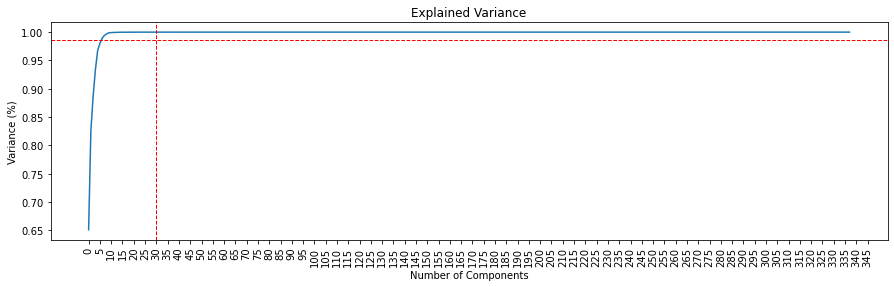

In [677]:
#Plotting Cumulative Summation for V variables Explained Variance
plt.figure(figsize=(15,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=30, c="r", ls="--", lw=1)
plt.axhline(y=0.986, c="r", ls="--", lw=1)
plt.xticks(np.arange(0, 350, 5), rotation=90)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

About 98.6% of the variance can be explained by 30 different factors. Set the n components parameter to 30.

In [678]:
#https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt/notebook#Concating-datafrms-to-get-PCA-of-V-features
def PCA_change(datafrm, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(datafrm[cols])
    principaldatafrm = pd.DataFrame(principalComponents)
    datafrm.drop(cols, axis=1, inplace=True)
    principaldatafrm.rename(columns=lambda x: str(prefix)+str(x), inplace=True)
    datafrm = pd.concat([datafrm, principaldatafrm], axis=1)
    
    return datafrm

In [679]:
datafrm = PCA_change(datafrm, mas_v, prefix='PCA_V_', n_components=30)

In [680]:
datafrm = reduce_mem_usage(datafrm)

Mem. usage decreased to 22.59 Mb (62.1% reduction)


In [681]:
training_data, testing_data = datafrm[datafrm['isFraud'] != 'testing_data'], datafrm[datafrm['isFraud'] == 'testing_data'].drop('isFraud', axis=1)

In [682]:
X = training_data.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y = training_data.sort_values('TransactionDT')['isFraud'].astype(bool)

In [683]:
testing_data = testing_data.sort_values('TransactionDT').drop(['TransactionDT','TransactionID'], axis=1)

In [684]:
target   = y
features = X.columns

In [685]:
print('training_data shape: %d, %d' %(training_data.shape[0],training_data.shape[1]))
print('testing_data shape: %d, %d' %(testing_data.shape[0],testing_data.shape[1]))
print('X shape: %d, %d' %(X.shape[0],X.shape[1]))
print('y shape: %d, 1' %(y.shape[0]))

training_data shape: 49927, 132
testing_data shape: 50000, 129
X shape: 49927, 129
y shape: 49927, 1


In [686]:
X_training_data, X_testing_data, y_training_data, y_testing_data = train_test_split(X, y, test_size=0.30, random_state=45, stratify=y)
print('training_data shape: %d, %d' %(X_training_data.shape[0],X_training_data.shape[1]))
print('testing_data shape: %d, %d' %(X_testing_data.shape[0],X_testing_data.shape[1]))
print('y shape: %d, 1' %(y_training_data.shape[0]))
print('y shape: %d, 1' %(y_testing_data.shape[0]))

training_data shape: 34948, 129
testing_data shape: 14979, 129
y shape: 34948, 1
y shape: 14979, 1


In [687]:
fillna(X_training_data)
fillna(X_testing_data)

In [688]:
target   = y_training_data
#features = X
features = X_training_data.columns
#features = X_training_data.columns

## Low Importance Features

In [689]:
# low_importance = []
# for i in sorted_importance_useful_rf:
#     if i[1] <= 0.002:
#         low_importance.append(i[0])
# low_importance

## Decission Tree

In [690]:
#Initial model with default values
base_tree = DecisionTreeClassifier(class_weight='balanced', random_state = 42)
base_tree.fit(X_training_data,y_training_data)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [691]:
print('Parameters currently in use:\n')
print(base_tree.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [692]:
print('The number of leaves of the base tree: {:d}'.format(base_tree.get_n_leaves()))
print('The depth of the base tree: {:d}'.format(base_tree.get_depth()))

The number of leaves of the base tree: 1562
The depth of the base tree: 62


In [693]:
base_tree_training_data_predict = base_tree.predict_proba(X_training_data)
base_tree_testing_data_predict = base_tree.predict_proba(X_testing_data)
print('base tree training_data auc:', roc_auc_score(y_training_data, base_tree_training_data_predict[:,1]))
print('base tree testing_data auc:', roc_auc_score(y_testing_data, base_tree_testing_data_predict[:,1]))

base tree training_data auc: 1.0
base tree testing_data auc: 0.6501100810850129


## Grid Search

In [694]:
#measure the quality of split
criterion = ['gini', 'entropy']
# Randomly takes a set of features at random and splits them as the strategy used to determine the split at each node.,
splitter = ['best', 'random']
# Max levels in tree
max_depth = [int(x) for x in np.linspace(10, 210, num = 11)]
max_depth.append(None)
# Min samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Min samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# best split variables
max_features = ['auto', 'log2', None]
# Max leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
#param for Minimal-Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
# Creating random grid
random_grid_search = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha}

In order to find the optimum hyperparameters, using random grid.
Making the base model first, then adjust it
Using a 3 fold stratified cross validation and a random search of parameters with auc roc score,

In [695]:
skf = StratifiedKFold(n_splits=3)
#use all available cores while conducting a search across 60 different combinations.
tree_rndm = RandomizedSearchCV(estimator = base_tree, param_distributions = random_grid_search, n_iter = 60, cv = skf, scoring = 'roc_auc', verbose=0,  n_jobs = -1)
#the random search model's fit
tree_rndm.fit(X_training_data, y_training_data)

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02, 0.025, 0.03, 0.035,
                                                      0.04, 0.045, 0.05],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210,
                                                      None],
                                        'max_features': ['auto', 'log2', None],
                                        'max_leaf_nodes': [10, 30, 50, 70, 90,
                                                           110, 130, 150, 170,
                                                           190, 210],
                                        'min_impurity_decrease': [0, 5e-05,
                                                                  0.0001,
                                                                  0.0002,
                                                                  0.0005, 0.001,
                                                                  0.0015, 0.002,
                                                                  0.005, 0.01,
                                                                  0.02],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 15, 30,
                                                              50, 100],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc')

In [696]:
best_rndm_tree_training_data_predict = tree_rndm.predict_proba(X_training_data)
best_rndm_tree_testing_data_predict = tree_rndm.predict_proba(X_testing_data)
print('best random tree training_data auc:', roc_auc_score(y_training_data, best_rndm_tree_training_data_predict[:,1]))
print('best random tree testing_data auc:', roc_auc_score(y_testing_data, best_rndm_tree_testing_data_predict[:,1]))

best random tree training_data auc: 0.8353479241772636
best random tree testing_data auc: 0.8228773809104903


In [697]:
print('Tuned best random Hyperparameters:\n')
print(tree_rndm.best_estimator_.get_params())

Tuned best random Hyperparameters:

{'ccp_alpha': 0.005, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 70, 'max_features': None, 'max_leaf_nodes': 130, 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [698]:
tree_rndm.best_estimator_.cost_complexity_pruning_path(X_training_data, y_training_data)

{'ccp_alphas': array([0.        , 0.00141039, 0.00141827, 0.00143482, 0.00145394,
        0.00146661, 0.00147833, 0.00150253, 0.00152185, 0.00152589,
        0.00153073, 0.00153632, 0.00154749, 0.00155656, 0.00157488,
        0.00158176, 0.00159149, 0.00162469, 0.00164731, 0.00165196,
        0.00168042, 0.00169007, 0.00169891, 0.00171921, 0.00172666,
        0.00173959, 0.00177845, 0.0017963 , 0.0018152 , 0.00182039,
        0.00183242, 0.00184136, 0.00184746, 0.00186125, 0.00186725,
        0.00187737, 0.00188821, 0.00189023, 0.00191975, 0.00192317,
        0.00192871, 0.00193286, 0.00199213, 0.00201225, 0.00203463,
        0.00204776, 0.0020521 , 0.00208895, 0.00213941, 0.00214324,
        0.00214467, 0.0021517 , 0.00217513, 0.00219986, 0.00225564,
        0.00226917, 0.00235694, 0.00235793, 0.00235977, 0.00236906,
        0.00242472, 0.00249356, 0.00250232, 0.00251394, 0.00254003,
        0.00260275, 0.00263691, 0.00268635, 0.00285897, 0.00301918,
        0.00303763, 0.00321743, 0.

In [699]:
print('The number of leaves of the best random tree: {:d}'.format(tree_rndm.best_estimator_.get_n_leaves()))
print('The depth of the best random tree: {:d}'.format(tree_rndm.best_estimator_.get_depth()))

The number of leaves of the best random tree: 16
The depth of the best random tree: 7


visualize features with importantce score > 0

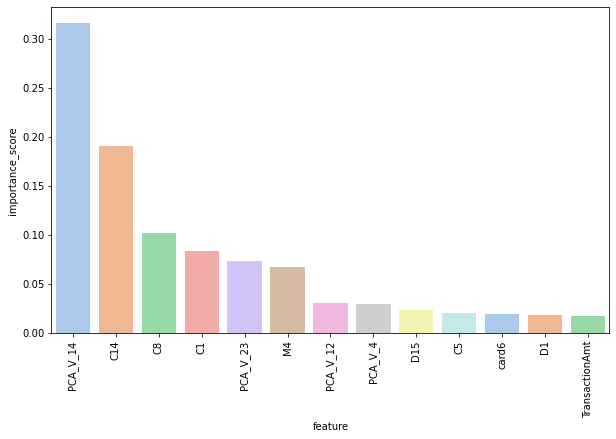

In [700]:
best_rndm_tree = tree_rndm.best_estimator_
plt.figure(figsize=(10,6))
sorted_importance_tree = sorted(zip(X_training_data.columns, best_rndm_tree.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_useful_tree = [ i for i in sorted_importance_tree if i[1] > 0]
a, b = zip(*sorted_importance_useful_tree)
fp = pd.DataFrame({'feature':a, 'importance_score':b})[:15]
sns.barplot(x="feature", y="importance_score", data=fp, palette = 'pastel')
plt.xticks(rotation=90)
plt.show()

In [701]:
sorted_importance_useful_tree

[('PCA_V_14', 0.31711393558803386),
 ('C14', 0.19119567398831847),
 ('C8', 0.10258760392927155),
 ('C1', 0.08405924162438994),
 ('PCA_V_23', 0.07410702312762825),
 ('M4', 0.06805287593687986),
 ('PCA_V_12', 0.031199522701674975),
 ('PCA_V_4', 0.030392055346142408),
 ('D15', 0.024243460331657706),
 ('C5', 0.02108723673424288),
 ('card6', 0.019705062568231457),
 ('D1', 0.01855817499798583),
 ('TransactionAmt', 0.01769813312554292)]

In [702]:
gc.collect()

29661

## Rndom Forest

In [292]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
base_rf.fit(X_training_data, y_training_data)
base_rf_training_data_predict = base_rf.predict_proba(X_training_data)
base_rf_testing_data_predict = base_rf.predict_proba(X_testing_data)
print('base random forest training_data auc:', roc_auc_score(y_training_data, base_rf_training_data_predict[:,1]))
print('base random forest testing_data auc:', roc_auc_score(y_testing_data, base_rf_testing_data_predict[:,1]))

base random forest training_data auc: 1.0
base random forest testing_data auc: 0.8721077146000817


In [293]:
print('Parameters currently in use:\n')
print(base_rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### Grid Search On RandomForest

Number of trees in random forest

In [294]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 15)]
# measuring the quality of a split
criterion = ['gini', 'entropy']
# Max levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Min samples required to split a node
min_samples_split = [2, 5, 10, 15, 30, 50, 100]
# Min samples required 
min_samples_leaf = [1, 2, 4, 10, 20]
#variables to consider when looking for the best split
max_features = ['auto', 'log2', None]
#max_features = ['log2', None]
# Max leaf nodes
max_leaf_nodes = [int(x) for x in np.linspace(10, 210, num = 11)]
[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000 , 12000, 15000, None]
# Split threshold
min_impurity_decrease = [0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.02]
#param for Minimal-Cost-Complexity Pruning
ccp_alpha = [x for x in np.linspace(0, 0.05, num = 11)]
bootstrap = [True, False]
# Create the random grid
random_grid_search = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,               
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features,
               'max_leaf_nodes': max_leaf_nodes,
               'min_impurity_decrease': min_impurity_decrease,
               'ccp_alpha': ccp_alpha,
               'bootstrap': bootstrap}

Use the random grid to search for best hyperparameters<br>
First create the base model to tune: base_tree<br>
Random search of parameters with auc_roc scoring, using 3 fold stratified cross validation,

In [295]:
skf = StratifiedKFold(n_splits=3)
#use all available scores while conducting a search across 60 different combinations.
rf_random = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid_search, n_iter = 60, 
                               cv = skf, scoring = 'roc_auc', verbose=0, random_state=42, n_jobs = -1)
# the random search model's fit
rf_random.fit(X_training_data, y_training_data)

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/noor/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': [0.0, 0.005, 0.01, 0.015,
                                                      0.02, 0.025, 0.03, 0.035,
                                                      0.04, 0.045, 0.05],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40...
                                        'max_features': ['auto', 'log2', None],
                                        'max_leaf_nodes': [10, 30, 50, 70, 90,
                                                           110, 130, 150, 170,
                                                           190, 210],
                                        'min_impurity_decrease': [0, 5e-05,
                                                                  0.0001,
                                                                  0.0002,
                                                                  0.0005, 0.001,
                                                                  0.0015, 0.002,
                                                                  0.005, 0.01,
                                                                  0.02],
                                        'min_samples_leaf': [1, 2, 4, 10, 20],
                                        'min_samples_split': [2, 5, 10, 15, 30,
                                                              50, 100],
                                        'n_estimators': [10, 80, 151, 222, 292,
                                                         363, 434, 504, 575,
                                                         646, 717, 787, 858,
                                                         929, 1000]},
                   random_state=42, scoring='roc_auc')

In [296]:
best_random_rf_training_data_predict = rf_random.predict_proba(X_training_data)
best_random_rf_testing_data_predict = rf_random.predict_proba(X_testing_data)
print('best random forest training_data auc from randomized search:', roc_auc_score(y_training_data, best_random_rf_training_data_predict[:,1]))
print('best random tree testing_data auc from randomized search:', roc_auc_score(y_testing_data, best_random_rf_testing_data_predict[:,1]))

best random forest training_data auc from randomized search: 0.9560387869262261
best random tree testing_data auc from randomized search: 0.8719104541778092


In [297]:
print('Tuned best random rf Hyperparameters:\n')
print(rf_random.best_estimator_.get_params())

Tuned best random rf Hyperparameters:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 60, 'max_features': 'log2', 'max_leaf_nodes': 150, 'max_samples': None, 'min_impurity_decrease': 5e-05, 'min_samples_leaf': 20, 'min_samples_split': 100, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 646, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


visualize features with importantce score > 0

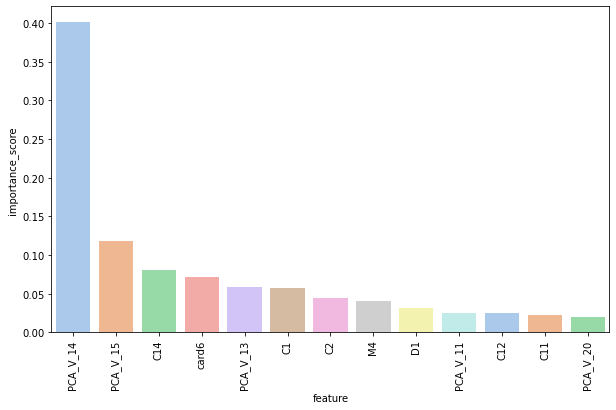

In [298]:
best_rndm_tree = tree_rndm.best_estimator_
plt.figure(figsize=(10,6))
sorted_importance_rf = sorted(zip(X_training_data.columns, best_rndm_tree.feature_importances_), key=lambda t:t[1], reverse=True)
sorted_importance_useful_rf = [ i for i in sorted_importance_rf if i[1] > 0]
a, b = zip(*sorted_importance_useful_rf)
fp = pd.DataFrame({'feature':a, 'importance_score':b})[:15]
sns.barplot(x="feature", y="importance_score", data=fp, palette = 'pastel')
plt.xticks(rotation=90)
plt.show()

In [299]:
sorted_importance_useful_rf

[('PCA_V_14', 0.4017984829693024),
 ('PCA_V_15', 0.11834915146584939),
 ('C14', 0.08134651736035921),
 ('card6', 0.07200299137905977),
 ('PCA_V_13', 0.0592818942943862),
 ('C1', 0.05712831684978856),
 ('C2', 0.0444384307945346),
 ('M4', 0.04124981543693146),
 ('D1', 0.031107414746832155),
 ('PCA_V_11', 0.0255446120760907),
 ('C12', 0.02519391215892524),
 ('C11', 0.022832910709018082),
 ('PCA_V_20', 0.019725549758922156)]

## Final Model

As Decision Tree is outperforming all the experiments done so far hence i am considering my final model as decision tree

### ROC on Final Model

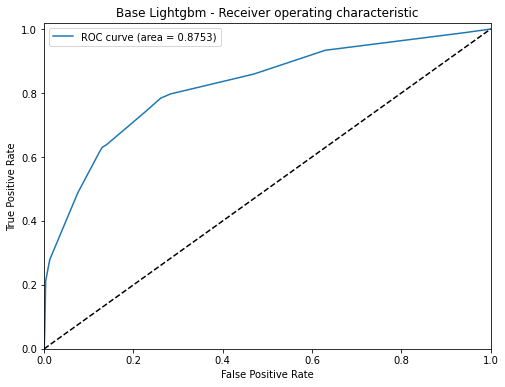

In [703]:
#Roc of base model
y_scores = best_rndm_tree_testing_data_predict[:,1]
fpr, tpr, thresholds = roc_curve(y_testing_data, y_scores)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % (auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Base Lightgbm - Receiver operating characteristic')
plt.legend(loc="best")

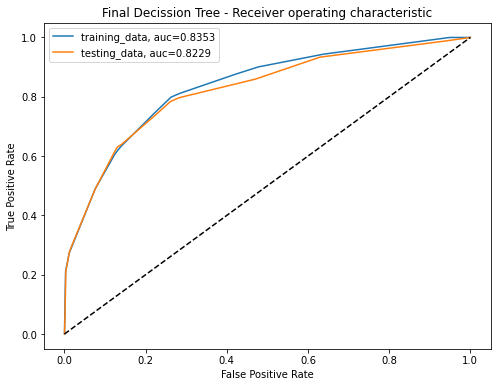

In [704]:
# auc of training_data of first grid search
plt.figure(figsize=(8,6))
fpr, tpr, thresh = roc_curve(y_training_data, best_rndm_tree_training_data_predict[:,1])
auc = roc_auc_score(y_training_data, best_rndm_tree_training_data_predict[:,1])
plt.plot(fpr,tpr,label="training_data, auc="+str(round(auc,4)))
# auc of testing_data
fpr, tpr, thresh = roc_curve(y_testing_data, best_rndm_tree_testing_data_predict[:,1])
auc = roc_auc_score(y_testing_data, best_rndm_tree_testing_data_predict[:,1])
plt.plot(fpr,tpr,label="testing_data, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Decission Tree - Receiver operating characteristic')
plt.show()

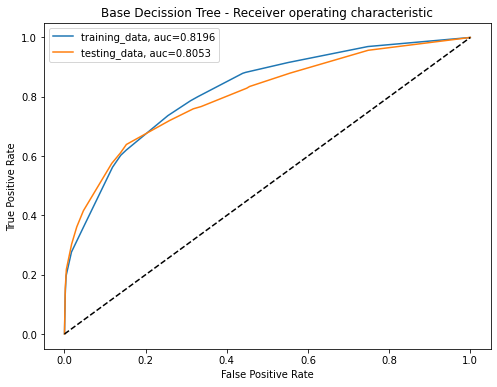

In [302]:
# auc of training_data of second grid search
plt.figure(figsize=(8,6))
fpr, tpr, thresh = roc_curve(y_training_data, best_rndm_tree_training_data_predict[:,1])
auc = roc_auc_score(y_training_data, best_rndm_tree_training_data_predict[:,1])
plt.plot(fpr,tpr,label="training_data, auc="+str(round(auc,4)))
# auc of testing_data
fpr, tpr, thresh = roc_curve(y_testing_data, best_rndm_tree_testing_data_predict[:,1])
auc = roc_auc_score(y_testing_data, best_rndm_tree_testing_data_predict[:,1])
plt.plot(fpr,tpr,label="testing_data, auc="+str(round(auc,4)))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Decission Tree - Receiver operating characteristic')
plt.show()

In [303]:
import scikitplot as skplt

### Lift Curve

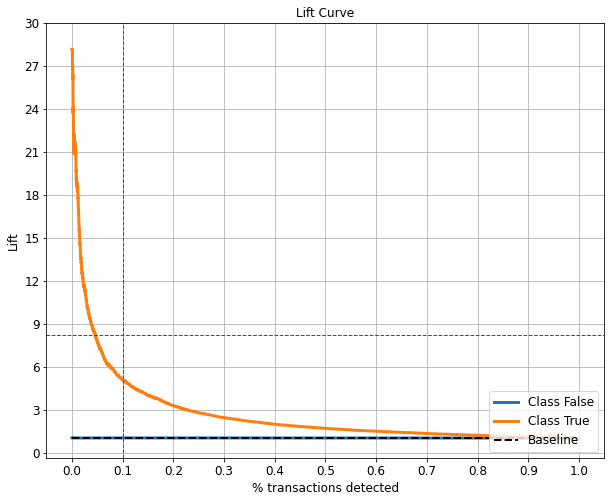

In [304]:
skplt.metrics.plot_lift_curve(y_testing_data, best_rndm_tree_testing_data_predict, figsize=(10,8),text_fontsize='large')
plt.xlabel('% transactions detected')
plt.axvline(x=0.1, c="r", ls="--", lw=1)
plt.axhline(y=8.2, c="r", ls="--", lw=1)
plt.yticks(np.arange(0, 31, 3))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

### cumulative gains curve

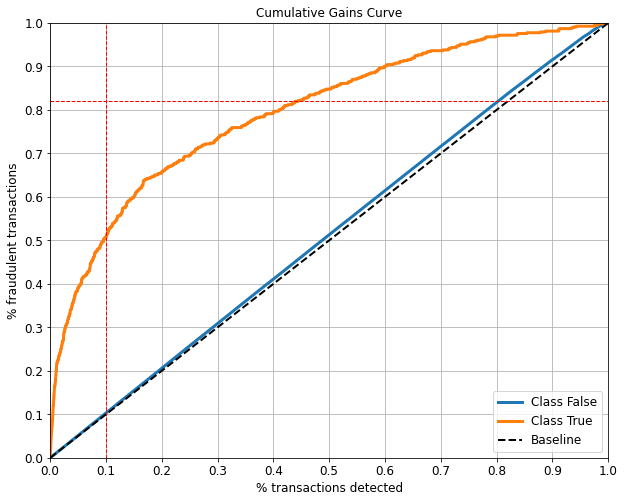

In [305]:
skplt.metrics.plot_cumulative_gain(y_testing_data, best_rndm_tree_testing_data_predict, figsize=(10,8),text_fontsize='large')
plt.axvline(x=0.1, c="r", ls="--", lw=1)
plt.axhline(y=0.82, c="r", ls="--", lw=1)
plt.xlabel('% transactions detected')
plt.ylabel('% fraudulent transactions')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.show()

## Confusion Matrix on Final Model

Confusion matrix, without normalization
[[10704  3742]
 [  149   383]]
Normalized confusion matrix
[[0.74096636 0.25903364]
 [0.28007519 0.71992481]]


<Figure size 720x432 with 0 Axes>

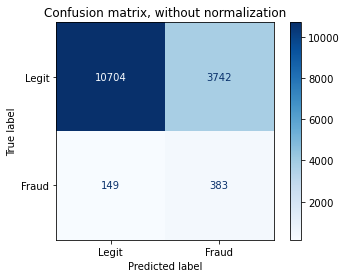

<Figure size 720x432 with 0 Axes>

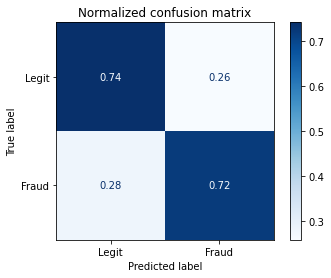

In [306]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    plt.figure(figsize=(10, 6))
    disp = plot_confusion_matrix(best_rndm_tree, X_testing_data, y_testing_data,
                                 display_labels=['Legit','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    
    print(title)
    print(disp.confusion_matrix)

In [307]:
#plt.show()

## COnclusion

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","reg","n_estimators","Depth","training_dataAuc","CvAuc"]
x.add_row(['logisticRegression','l2','_','_','86.35','83.35'])
x.add_row(['DT','_','_',7,'86.55','83.36'])
x.add_row(['RF','_','900',13,'94.33','87.44'])

In [308]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","reg","n_estimators","Depth","training_dataAuc","testing_dataAuc"]
x.add_row(['logisticRegression','l2','_','_','81.93','80.50'])
x.add_row(['BoostingTree','_','100','90','98.69','87.15'])
x.add_row(['Decisiontree','_','_',10,'81.96','80.20'])
x.add_row(['RandomForest','_','646',60,'95.92','86.26'])

In [309]:
print(x)

+--------------------+-----+--------------+-------+------------------+-----------------+
|       Model        | reg | n_estimators | Depth | training_dataAuc | testing_dataAuc |
+--------------------+-----+--------------+-------+------------------+-----------------+
| logisticRegression |  l2 |      _       |   _   |      81.93       |      80.50      |
|    BoostingTree    |  _  |     100      |   90  |      98.69       |      87.15      |
|    Decisiontree    |  _  |      _       |   10  |      82.95       |      80.20      |
|    RandomForest    |  _  |     646      |   60  |      95.92       |      86.26      |
+--------------------+-----+--------------+-------+------------------+-----------------+


## References

https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/#logistic-regression-with-sgd-training_dataing
https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400
https://www.kaggle.com/c/ieee-fraud-detection/discussion/99987
https://www.kaggle.com/c/ieee-fraud-detection/discussion/107697#latesting_data-620107
https://github.com/KaustuvDash/IEEE-Fraud-Detection/blob/master/Part-1%20Fraud%20Detection%20Analysis%20on%20Transaction%20data%20and%20Feature%20Engineering.ipynb
https://www.kaggle.com/jesucristo/fraud-complete-eda
https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
https://www.kaggle.com/yasagure/places-after-the-decimal-point-tell-us-a-lot
https://github.com/LefanCheng/ML_Project_IEEE_Fraud_Detection_Kaggle/blob/master/IEEE%20CIS%20Fraud%20Detection%20-%20Fred%20Lefan%20Cheng%20-%20Final%20Version%20-%20Feb%202%2C%202020.ipynb
https://www.kaggle.com/jolly2136/eda-fe-xgb
https://www.kaggle.com/yasagure/fraud-makers-are-earnest-people-about-browser
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code
https://www.kaggle.com/competitions/ieee-fraud-detection/code
https://www.kaggle.com/code/jesucristo/fraud-complete-eda/notebook
https://www.kaggle.com/code/jazivxt/safe-box/notebook
https://www.kaggle.com/code/suoires1/fraud-detection-eda-and-modeling/notebook
https://www.kaggle.com/code/nroman/eda-for-cis-fraud-detection/notebook
https://www.kaggle.com/code/grazder/filling-card-nans/notebook
https://www.kaggle.com/code/nroman/eda-for-cis-fraud-detection/notebook
https://www.kaggle.com/code/yasagure/places-after-the-decimal-point-tell-us-a-lot/notebook
https://www.kaggle.com/code/yasagure/fraud-makers-may-be-earnest-people-about-browser?scriptVersionId=21010669
https://www.kaggle.com/code/gamzebayir/fraud-detection-choosing-base-model
https://www.kaggle.com/code/arababudu/aba-ieee-cis-feature-engineering-all
https://medium.com/@gtavicecity581/ieee-fraud-detection-469398ce1ac4